In [1]:
# Importing all libraries necessary for the assignment
!pip install shap
!pip install lime
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o


import pandas as pd
import numpy as np
import shap
import lime
from lime import lime_tabular
import sklearn
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from matplotlib.pyplot import figure
from sklearn.tree import export_graphviz
#import pydot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns


plt.rcParams["figure.figsize"] = (32, 24)

In [2]:

# Setting up maximum runtime for the AutoML
min_mem_size = 6
run_time = 222

In [3]:
# Setting up memory
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)
     

1


In [4]:

# 65535 Highest port no
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:34543 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-11.0.17+8 (build 11.0.17+8, mixed mode)
  Starting server from C:\Users\Dell\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Dell\AppData\Local\Temp\tmpmlkl12uy
  JVM stdout: C:\Users\Dell\AppData\Local\Temp\tmpmlkl12uy\h2o_Dell_started_from_python.out
  JVM stderr: C:\Users\Dell\AppData\Local\Temp\tmpmlkl12uy\h2o_Dell_started_from_python.err
  Server is running at http://127.0.0.1:34543
Connecting to H2O server at http://127.0.0.1:34543 ... successful.


--------------------------  -----------------------------
H2O_cluster_uptime:         05 secs
H2O_cluster_timezone:       America/New_York
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.4
H2O_cluster_version_age:    2 months and 12 days
H2O_cluster_name:           H2O_from_python_Dell_jvg11i
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.977 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:34543
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.9.13 final
--------------------------  -----------------------------

In [5]:
# Reading CSV file into Pandas DataFrame
pandas_df = pd.read_csv(
    "https://raw.githubusercontent.com/Akshathapatil1998/ML_Data_Cleaning_and_Feature_Selection_Chronic_Kidney_Disease_Prediction/main/new_model.csv")

In [6]:
#Renaming columns 
pandas_df = pandas_df.rename(columns={"Bp":"BloodPressure","Sg":"SpecificGravity","Al":"Albumin","Su":"Sugar","Rbc":"RedBloodCell","Bu":"BloodUrea","Sc":"SerumCreatinine","Sod":"Sodium","Pot":"Pottasium","Hemo":"Hemoglobin","Wbcc":"WhiteBloodCellsCont","Rbcc":"RedBloodCellsCont","Htn":"Hypertension","Class":"ChronicKidneyDisease"})

In [7]:
X = pandas_df.drop(["ChronicKidneyDisease"], axis=1)  # Training Feature
Y = pandas_df["ChronicKidneyDisease"]  # Target

In [8]:
(
    x_train,
    x_test,
    y_train,
    y_test,
) = train_test_split(  # Splitting Data into Training and Test
    X, Y, test_size=0.1, random_state=42
)
x_train_100 = shap.utils.sample(
    x_train, 100
)  # Taking 100 samples out for SHAP analysis as it is a computationally expensive process
x_test_100 = shap.utils.sample(
    x_test, 100
)  # Taking 100 samples out for SHAP analysis as it is a computationally expensive process

## Fitting a Linear Model

In [9]:

linear_model = sklearn.linear_model.LinearRegression()  # Initializing a Linear Model
linear_model.fit(x_train, y_train)  # Training a linear model

LinearRegression()

In [10]:

# Scaling the data using Min-Max scaling for the purpose of evaluating Co-efficients, as non scaled data may mislead while we evaluate the co-efficients
df = pandas_df.drop("ChronicKidneyDisease", axis=1)
df_norm = (df - df.min()) / (df.max() - df.min())
df_norm = pd.concat((df_norm, pandas_df.ChronicKidneyDisease), 1)

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


In [11]:
# OLS Linear Model Summary
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(pandas_df['ChronicKidneyDisease'], pandas_df[['BloodPressure','SpecificGravity','Albumin','RedBloodCell','Sugar','SerumCreatinine','BloodUrea','Sodium','Pottasium','Hemoglobin','RedBloodCellsCont','WhiteBloodCellsCont','Hypertension']]).fit()

# Print out the statistics
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     ChronicKidneyDisease   R-squared (uncentered):                   0.864
Model:                              OLS   Adj. R-squared (uncentered):              0.860
Method:                   Least Squares   F-statistic:                              189.7
Date:                  Sat, 18 Mar 2023   Prob (F-statistic):                   8.22e-159
Time:                          14:23:09   Log-Likelihood:                         -73.993
No. Observations:                   400   AIC:                                      174.0
Df Residuals:                       387   BIC:                                      225.9
Df Model:                            13                                                  
Covariance Type:              nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
BloodPressure           0.0024      0.001      2.065      0.040       0.000       0.005
SpecificGravity         1.7868      0.341      5.243      0.000       1.117       2.457
Albumin                 0.0823      0.016      5.287      0.000       0.052       0.113
RedBloodCell           -0.0549      0.051     -1.076      0.283      -0.155       0.045
Sugar                   0.0480      0.015      3.101      0.002       0.018       0.079
SerumCreatinine         0.0047      0.004      1.154      0.249      -0.003       0.013
BloodUrea              -0.0014      0.000     -3.067      0.002      -0.002      -0.000
Sodium                 -0.0019      0.002     -0.839      0.402      -0.006       0.003
Pottasium               0.0017      0.006      0.285      0.776      -0.010       0.013
Hemoglobin             -0.0814      0.009     -9.244      0.000      -0.099      -0.064
RedBloodCellsCont      -0.0525      0.025     -2.080      0.038      -0.102      -0.003
WhiteBloodCellsCont   1.08e-05   6.15e-06      1.756      0.080   -1.29e-06    2.29e-05
Hypertension            0.1511      0.041      3.688      0.000       0.071       0.232
==============================================================================
Omnibus:                       36.695   Durbin-Watson:                   1.140
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.014
Skew:                           0.309   Prob(JB):                     0.000202
Kurtosis:                       2.200   Cond. No.                     2.02e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Interpreting Regression Co-efficients

## P-Values
- __Hemoglobin__ has a p-value of 0.0 which is lesser than 0.05 so it is a significant feature
- __Hypertension__ has a p-value 0.0 which is lesser than 0.05 so it is a significant feature
- __Blood Pressure__ has a p-value of 0.040 which is lesser than 0.05 so it is a significant feature
- __Specific Gravity__ has a p-value of 0.0 which is lesser than 0.05 so it is a significant feature
- __Albumin__ has a p-value of 0.0 which is lesser than 0.05 so it is a significant feature
- __Sugar__ has a p-value of 0.002 which is lesser than 0.05 so it is a significant feature
- __Blood Urea__ has a p-value of 0.002 which is lesser than 0.05 so it is a significant feature

The relationship is significant when the p value for the predictor variables is less than 0.05,but if it is higher than 0.05 the result is non-significant. From the OLS method, the above mentioned  variables have P-Value less that 0.05, hence it can be interpreted that these variables are significant variables and any change to this variables have significant impact on the target(Chronic Kidney Disease). 

## Model Co-efficients

The positive or negative value of a co-eficient tells us if there is a positve or a negtive correlationship between the target and predictors. A positive value indicates that the value of target increases if the value of co-efficient increases and vice-versa. Whereas the negative values indicates that the value of target increases if the value of co-efficient decreases and vice versa.

As seen in the co-efficient coloumn in the above table

- Value for the variable specific gravity is highest = 	1.7868


High absolute values of co-efficients can be used to get an idea of the importance of variables in a linear regression. Here, as stated above Specific Gravity is the most important variables to predict target i.e. Chronic Kidney Disease.

Also, it signifies that Higher specific gravity of the blood higher is the chances of person is proned to Chronic Kidney Disease.

## Skew and Kurtosis

- A skewness value of 0.309 indicates that the distribution of data is slightly right-skewed, but the skewness is not very strong.

- A kurtosis value of 2.200 indicates that the distribution of data has more data in the tails and is slightly more peaked than a normal distribution (which has a kurtosis value of 3). 


## Durbin-Watson

The Durbin-Watson test is a statistical test to detect auto-correlation in the residuals of a regression analysis. Its range is 0 to 4.

Value of 2 indicates that no auto correlation is detected
Value between 0 to 2 indicates that there is positive auto correlation detected
Value between 2 to 4 indicates that there is negatibe auto correlation detected
Our model has a DW score of 1.140 which could be interpreted as a positive auto-correlation in the residuals of regression.

## Jarque-Bera Test

The JB test is known as the test of Normality, irrespective if the data has skew or kurtosis. If it is far from zero, it signals the data do not have a normal distribution. Our JB value is 17.014 which again re-inforces the interpretation we got from Skew and Kurtosis.

# Fit Tree Based Model

In [12]:
# Setting the max_dept to 3 for the purpose of ease of explainbility and readability
tree_model = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=10)
tree_model.fit(x_train, y_train)
     

RandomForestRegressor(max_depth=3, n_estimators=10, random_state=0)

- __max_depth:__ This argument sets the maximum depth of each decision tree in the random forest. In this case, we are setting it to 3 for the purpose of ease of explainability and readability.
- __random_state:__ This argument sets the random seed for the random number generator used by the random forest. Setting a random seed ensures that the same results will be produced each time the code is run, which can be helpful for reproducibility.
- __n_estimators:__ This argument sets the number of decision trees in the random forest. In this case, we are setting it to 10.

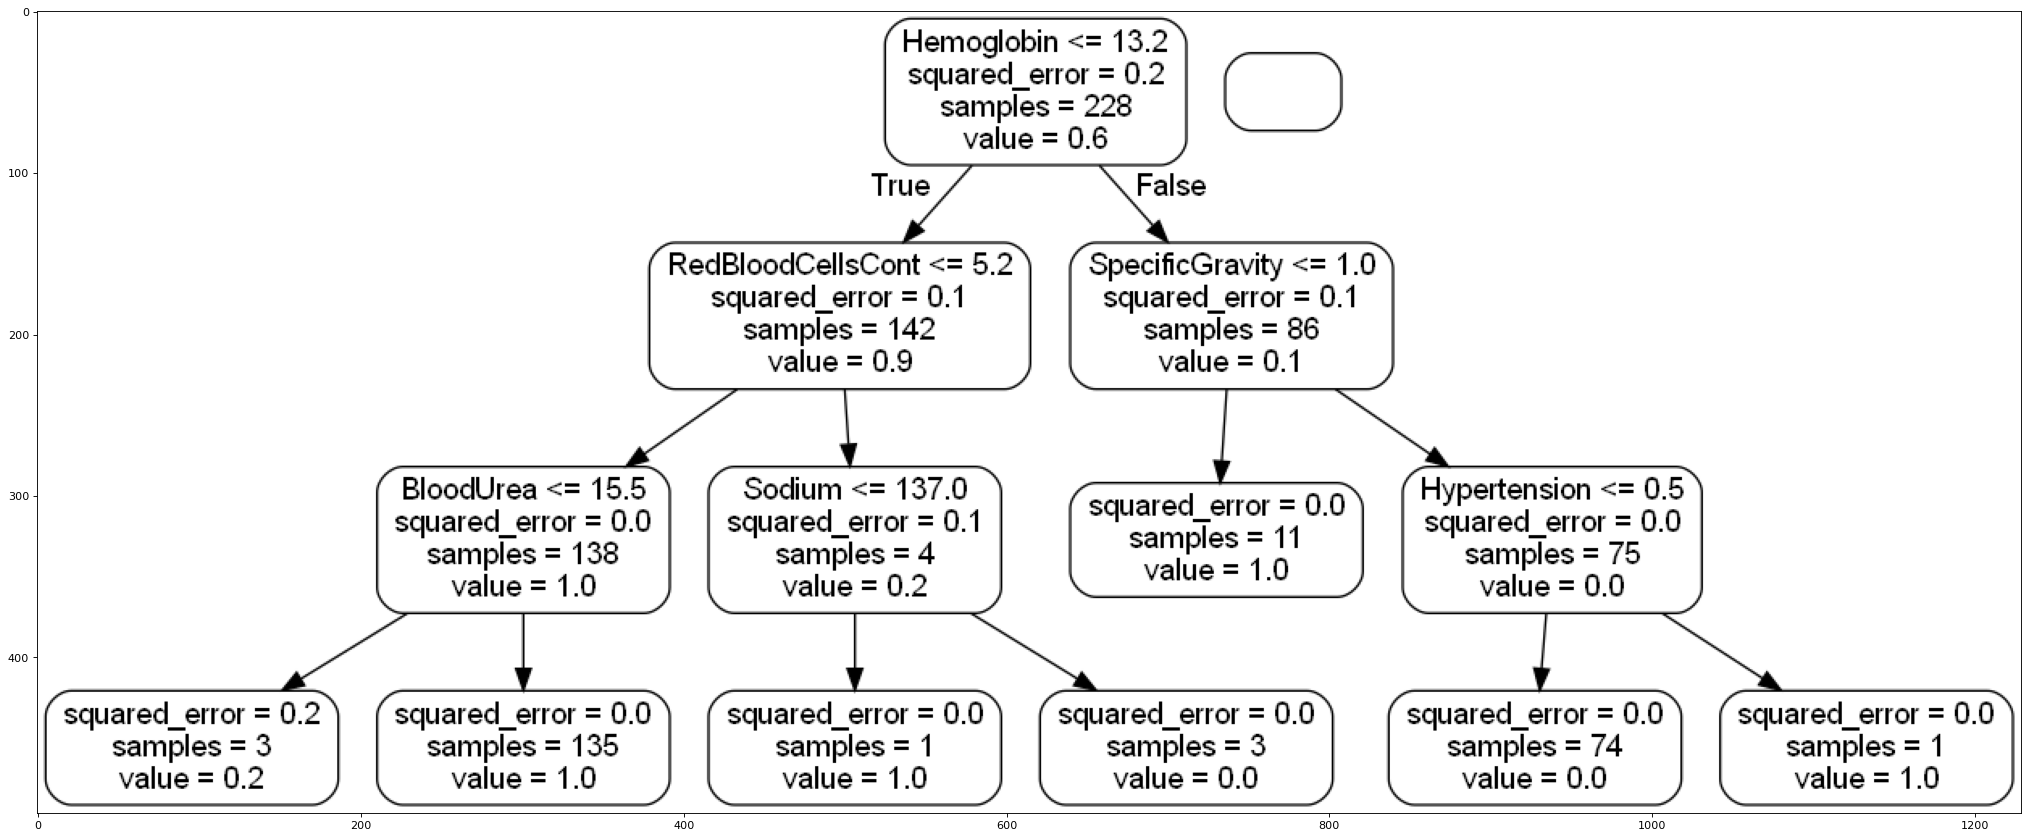

In [13]:

import pydot
# Visualization of Nodes for the purpose of explainability
figure(figsize=(32, 24), dpi=80)
tree = tree_model.estimators_[0]
export_graphviz(
    tree,
    out_file="tree.dot",
    feature_names=list(x_train.columns),
    rounded=True,
    precision=1,
)
(graph,) = pydot.graph_from_dot_file("tree.dot")
graph.write_png("tree.png")
img = mpimg.imread("tree.png")
imgplot = plt.imshow(img)
plt.show()


# Interpreting Nodes of a Tree-Based Model

Random Forest Regressor works on the concept of the wisdom of the crowd. The above decision tree is one of the many trees involved in predicting the target variable. Each decision tree regression predicts a number as an output for a given input. Random forest regression takes the average of those predictions as its final output.

As usual, the tree has conditions on each internal node and a value associated with each leaf (i.e. the value to be predicted). But additionally, we’ve plotted out the value at each internal node i.e. the mean of the response variables in that region.

Let us try to understand how the above decision tree is working by interpreting the nodes starting from the extreme left side as leaf 1.

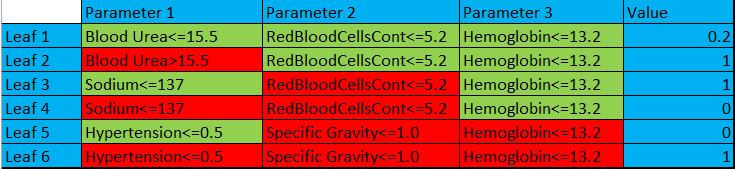

Refering to the above figure to understand the nodes The first leaf gets gains from all parameters as the condition satisfied for all 3 parameters The second leaf gets gains from parameters 2, and 3 but not from parameters 1 .The third leaf gets gains from parameter 1 and 3 .The fourth leaf gets gain from parameter 1 and 2.And Similarly, the red marked cells are the losses incurred and Green marked cells are the gains incurred from the parameters which give us output as values for this specific decision tree

In [14]:
# Get numerical feature importances
tree_importances = list(tree_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [
    (feature, round(importance, 2))
    for feature, importance in zip(x_train.columns, tree_importances)
]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

In [15]:

# Print out the feature and importances
[print("Variable: {:20} Importance: {}".format(*pair)) for pair in feature_importances];

Variable: Hemoglobin           Importance: 0.74
Variable: SpecificGravity      Importance: 0.18
Variable: RedBloodCellsCont    Importance: 0.03
Variable: Albumin              Importance: 0.01
Variable: BloodUrea            Importance: 0.01
Variable: Sodium               Importance: 0.01
Variable: Hypertension         Importance: 0.01
Variable: BloodPressure        Importance: 0.0
Variable: Sugar                Importance: 0.0
Variable: RedBloodCell         Importance: 0.0
Variable: SerumCreatinine      Importance: 0.0
Variable: Pottasium            Importance: 0.0
Variable: WhiteBloodCellsCont  Importance: 0.0


# Getting best model using H2O AutoML


In [16]:
 # Converting Pandas dataframe in H2O dataf
df = h2o.H2OFrame(pandas_df) 

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [17]:
 # Setting up the data split between training and test dataset.
pct_rows = 0.80 
df_train, df_test = df.split_frame([pct_rows])

In [18]:
 # Datatype of all attributes, here the result ("ChronicKidneyDisease") is int hence it can be solved using the regression. If this problem was supposed to solved using the classification
df.types 

{'BloodPressure': 'int',
 'SpecificGravity': 'real',
 'Albumin': 'int',
 'Sugar': 'int',
 'RedBloodCell': 'int',
 'BloodUrea': 'real',
 'SerumCreatinine': 'real',
 'Sodium': 'real',
 'Pottasium': 'real',
 'Hemoglobin': 'real',
 'WhiteBloodCellsCont': 'int',
 'RedBloodCellsCont': 'real',
 'Hypertension': 'real',
 'ChronicKidneyDisease': 'int'}

In [19]:
#printing shapes
print(df_train.shape)
print(df_test.shape)

(316, 14)
(84, 14)


In [20]:
# Setting up AutoML
def autoML(df_train, df_test):
    X = df_train.columns
    y = "ChronicKidneyDisease"

    X.remove(y)  # Removing the result frm our predictors data
 

    aml = H2OAutoML(max_runtime_secs=222, seed=1)  # Setting of AutoML
    aml.train(
        x=X, y=y, training_frame=df_train
    )  # Trainig the dataset on different models

    return df_train, df_test, aml


# Function to get best model from the AutoML leaderboard
def getBestModel(aml):
    model_index = 0
    glm_index = 0
    glm_model = ""
    aml_leaderboard_df = aml.leaderboard.as_data_frame()
    models_dict = {}

    for m in aml_leaderboard_df["model_id"]:
        models_dict[m] = model_index
        if "StackedEnsemble" not in m:
            break
        model_index = model_index + 1

    for m in aml_leaderboard_df["model_id"]:
        if "GLM" in m:
            models_dict[m] = glm_index
            break
        glm_index = glm_index + 1

    print(model_index)
    best_model = h2o.get_model(aml.leaderboard[model_index, "model_id"])
    return best_model
     

In [21]:
# Training AutoML 
autoML = autoML(df_train, df_test)  

AutoML progress: |
14:23:12.166: AutoML: XGBoost is not available; skipping it.
14:23:12.247: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.


14:23:12.966: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
14:23:14.230: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
14:23:14.381: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical befo

In [22]:

autoML[2].leaderboard  # Leaderbord of AutoML output

model_id                                                               rmse         mse        mae      rmsle    mean_residual_deviance
----------------------------------------------------------------  ---------  ----------  ---------  ---------  ------------------------
GBM_lr_annealing_selection_AutoML_1_20230318_142312_select_model  0.0973787  0.00948262  0.038195   0.0677456                0.00948262
StackedEnsemble_BestOfFamily_4_AutoML_1_20230318_142312           0.0985998  0.00972192  0.0454187  0.0688986                0.00972192
GBM_grid_1_AutoML_1_20230318_142312_model_164                     0.102436   0.0104931   0.0382219  0.0723874                0.0104931
GBM_grid_1_AutoML_1_20230318_142312_model_127                     0.102508   0.0105079   0.0460275  0.0738901                0.0105079
GBM_grid_1_AutoML_1_20230318_142312_model_174                     0.102584   0.0105234   0.0453396  0.0717724                0.0105234
GBM_grid_1_AutoML_1_20230318_142312_model_235                     0.102974   0.0106036   0.0407329  0.0732517                0.0106036
GBM_grid_1_AutoML_1_20230318_142312_model_40                      0.103154   0.0106408   0.0423682  0.0728125                0.0106408
GBM_grid_1_AutoML_1_20230318_142312_model_66                      0.103192   0.0106487   0.0517044  0.0723025                0.0106487
StackedEnsemble_BestOfFamily_5_AutoML_1_20230318_142312           0.104071   0.0108307   0.0235378  0.0682553                0.0108307
GBM_grid_1_AutoML_1_20230318_142312_model_199                     0.105234   0.0110742   0.0460574  0.0751056                0.0110742
[318 rows x 6 columns]

In [23]:

autoML_model = getBestModel(autoML[2])  # Getting Best Model
print(autoML_model)

0
Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_lr_annealing_selection_AutoML_1_20230318_142312_select_model


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    61                 61                          13743                  4            4            4             7             16            13.3279

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.0008986426229503904
RMSE: 0.029977368512769602
MAE: 0.012485497874739031
RMSLE: 0.022970641197510112
Mean Residual Deviance: 0.0008986426229503904

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.00948261979815697
RMSE: 0.0973787440777348
MAE: 0.0381949831074766
RMSLE: 0.06774

# SHAP, Partial Dependence Plot, Individual Conditional Expectation Analysis for AutoML Best Model

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

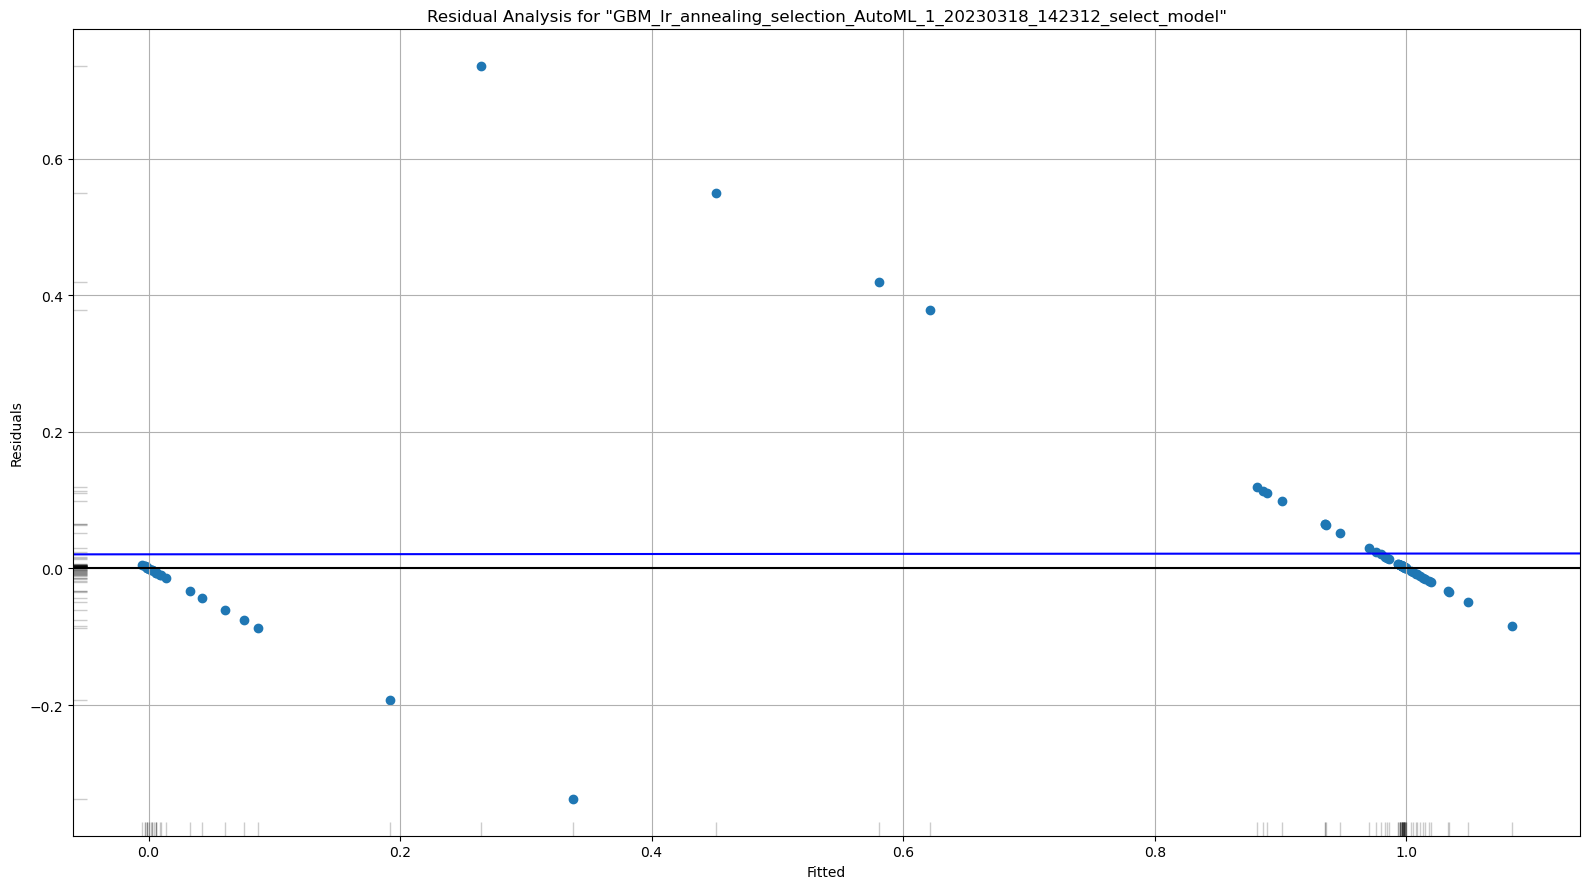

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

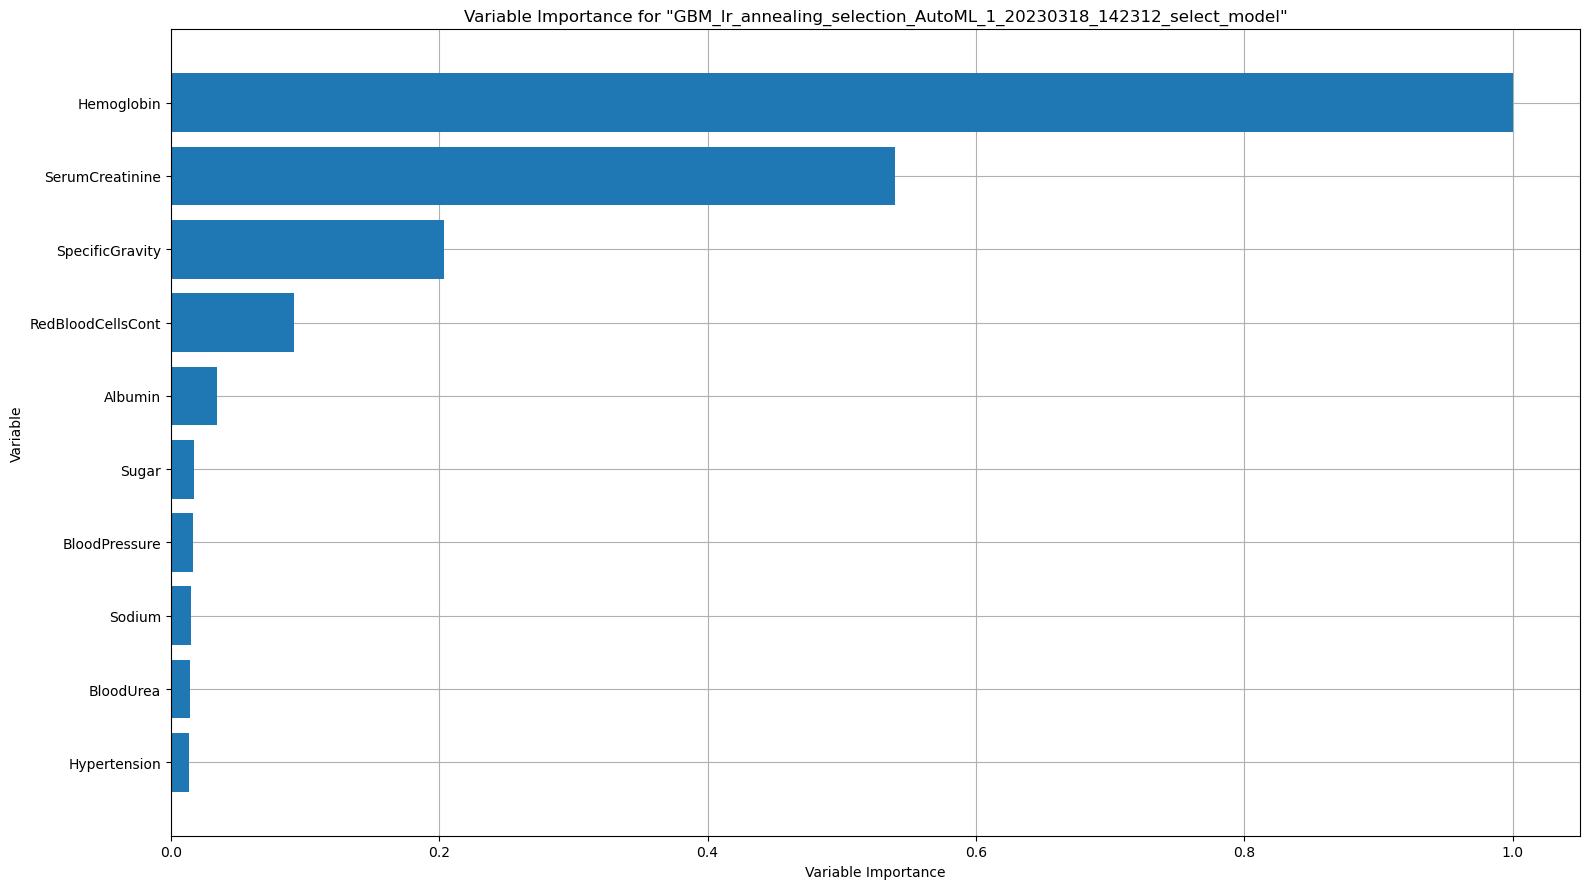

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

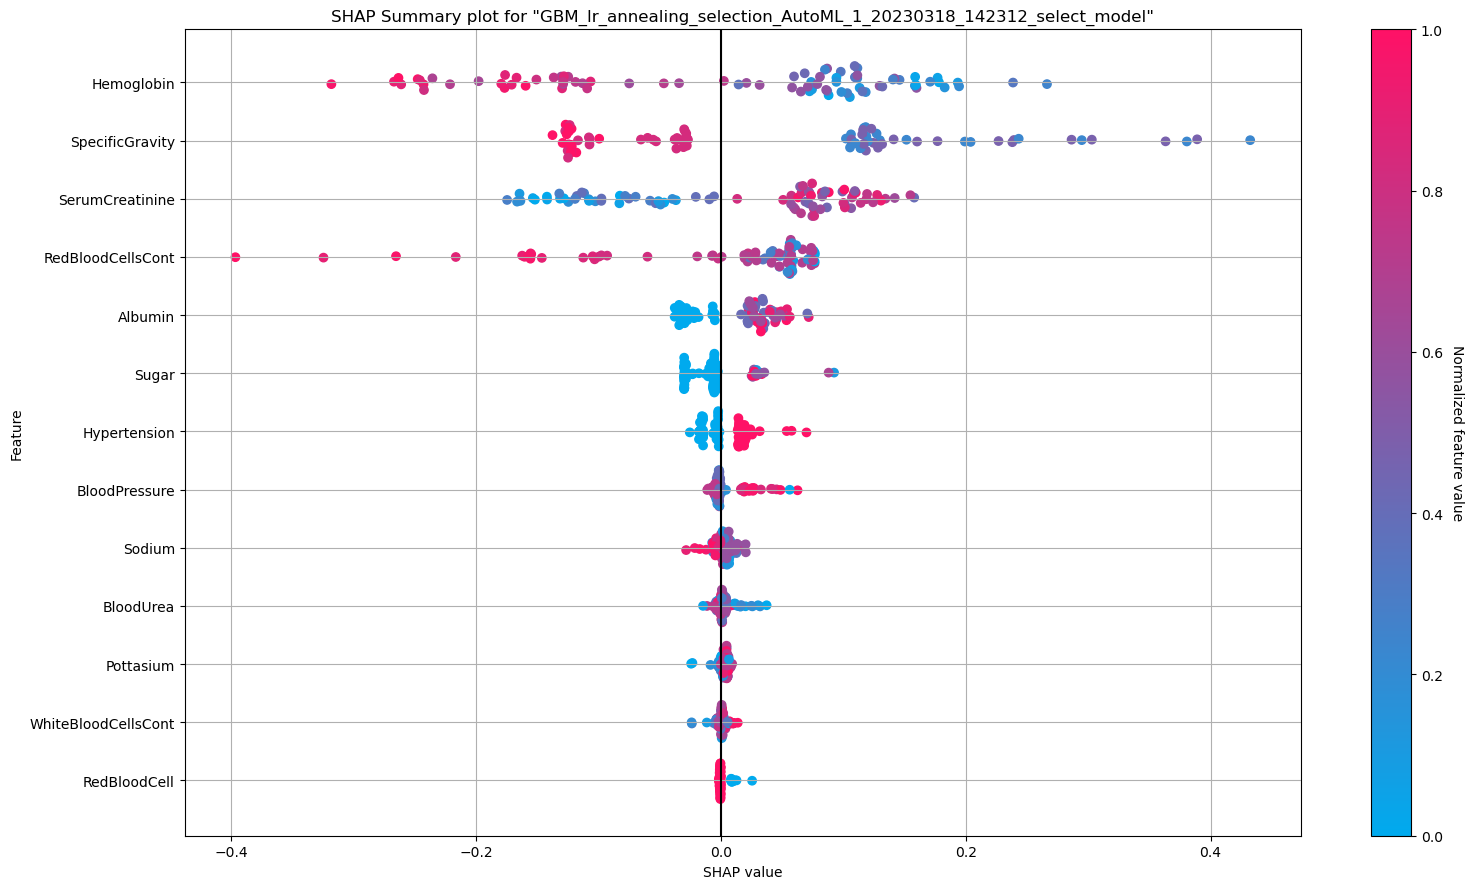

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

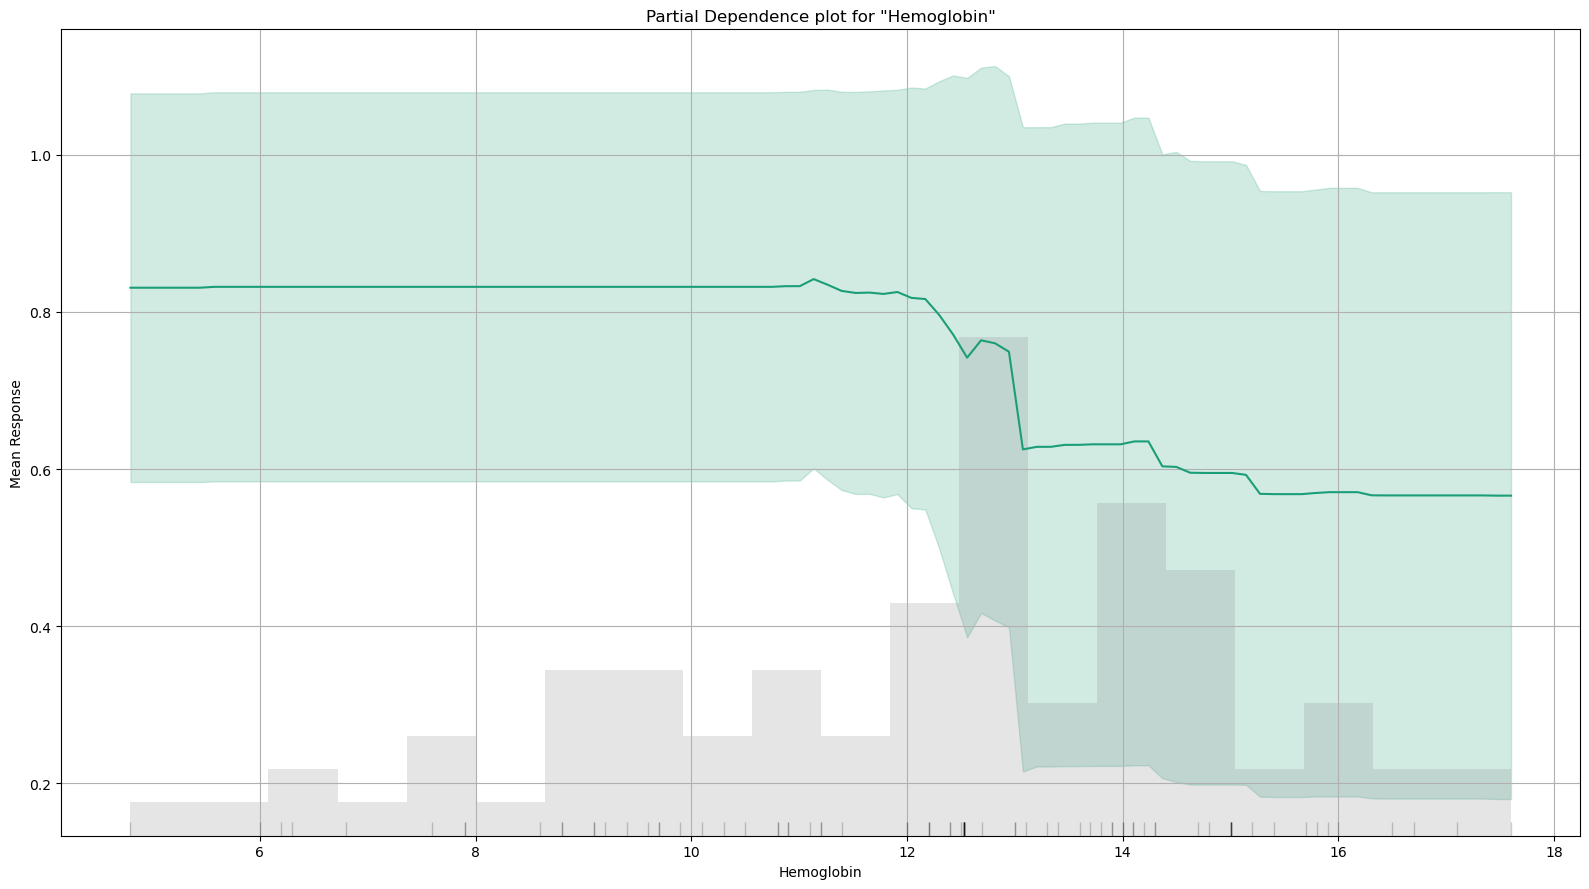

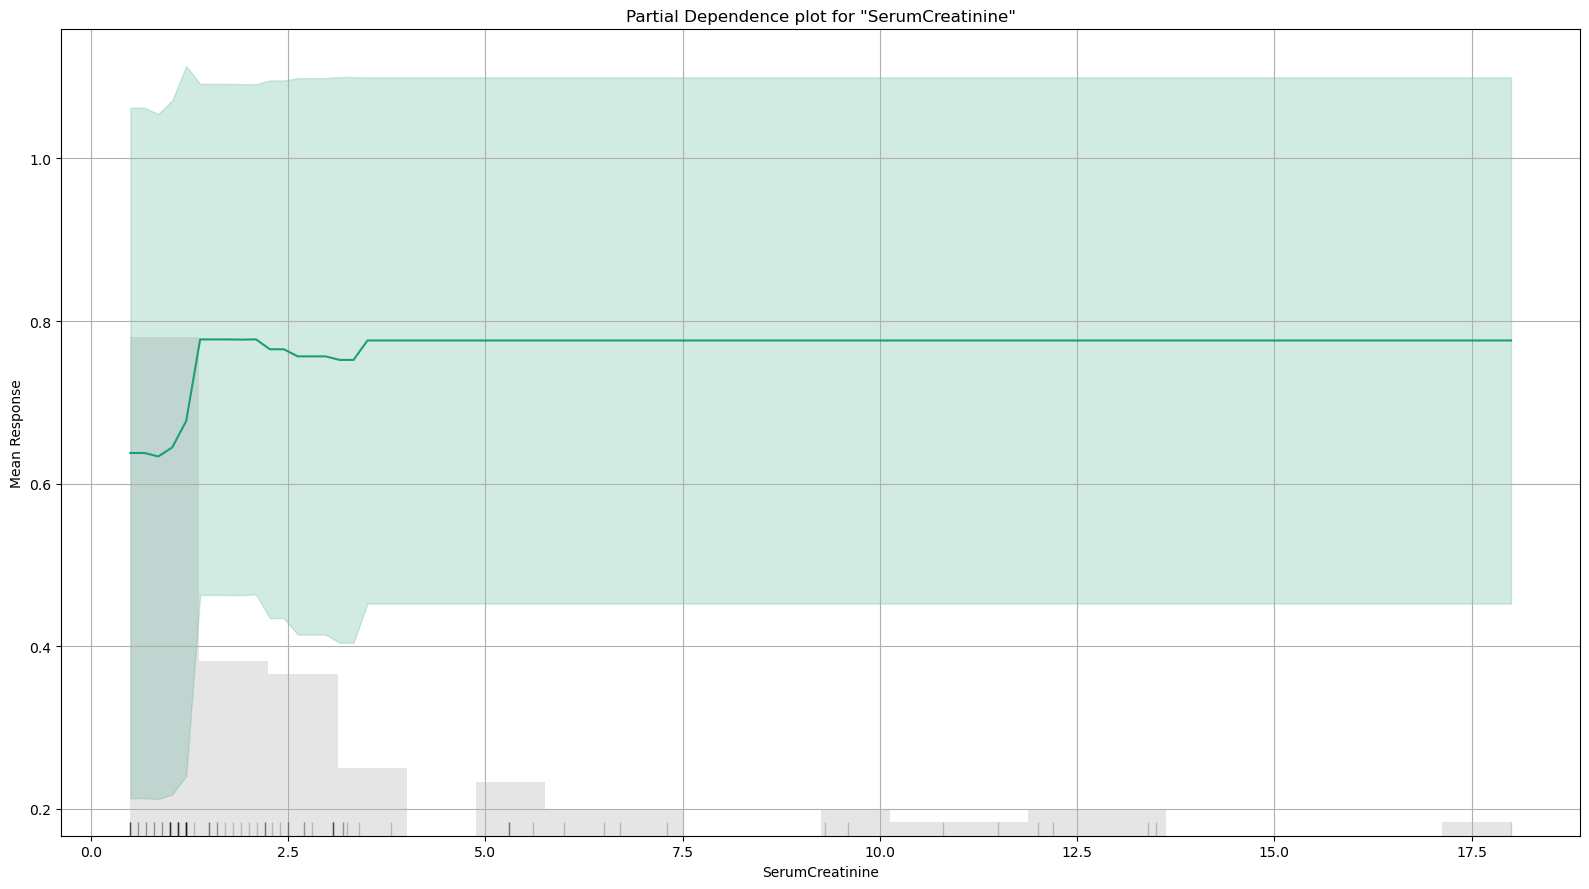

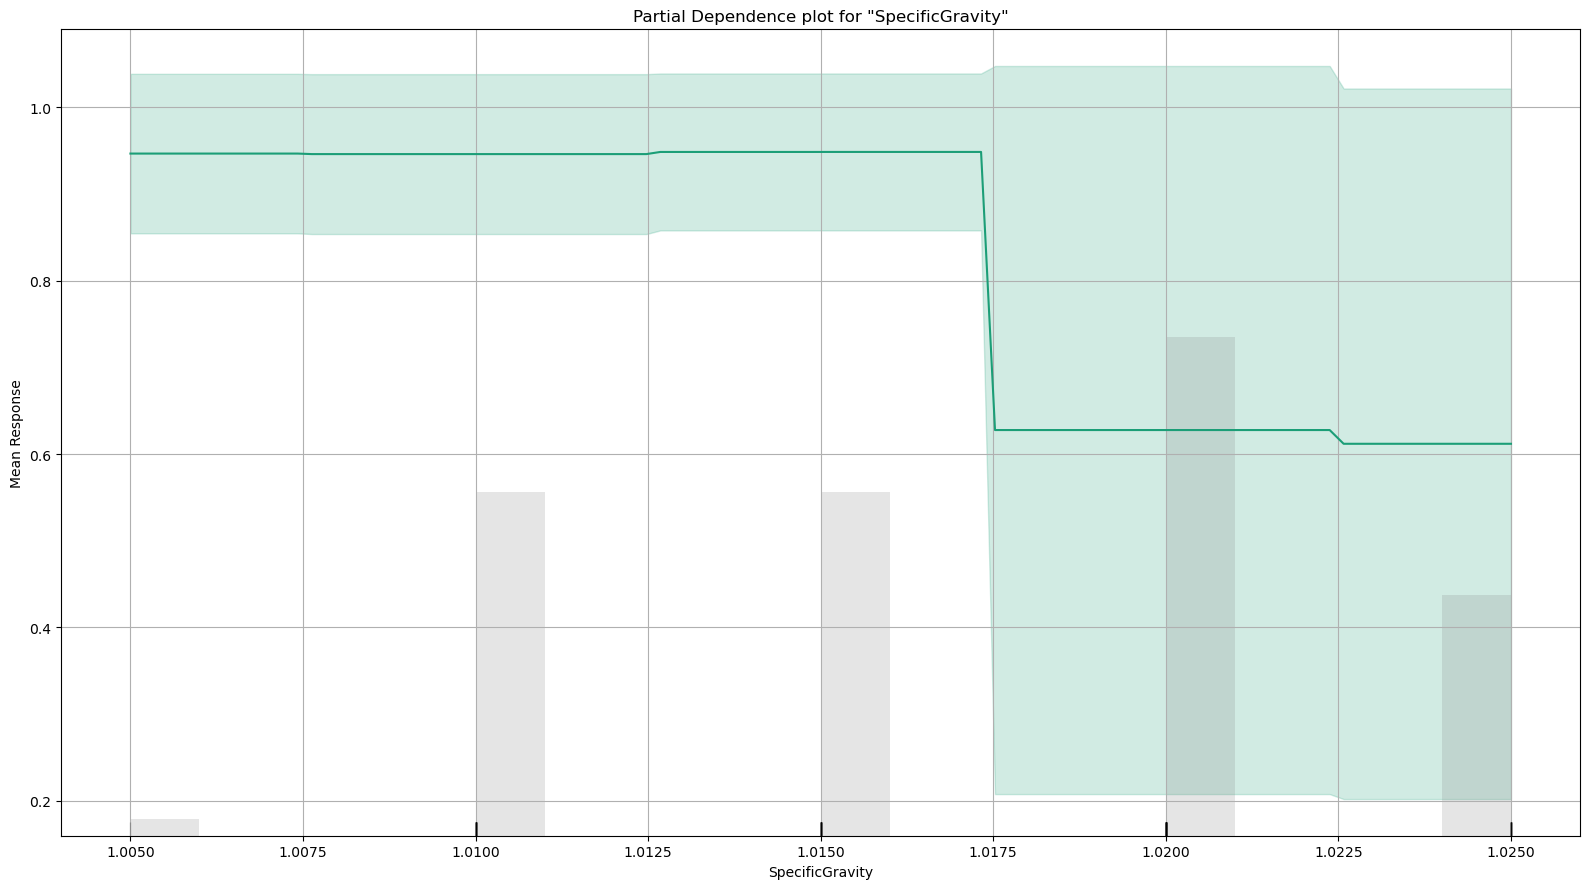

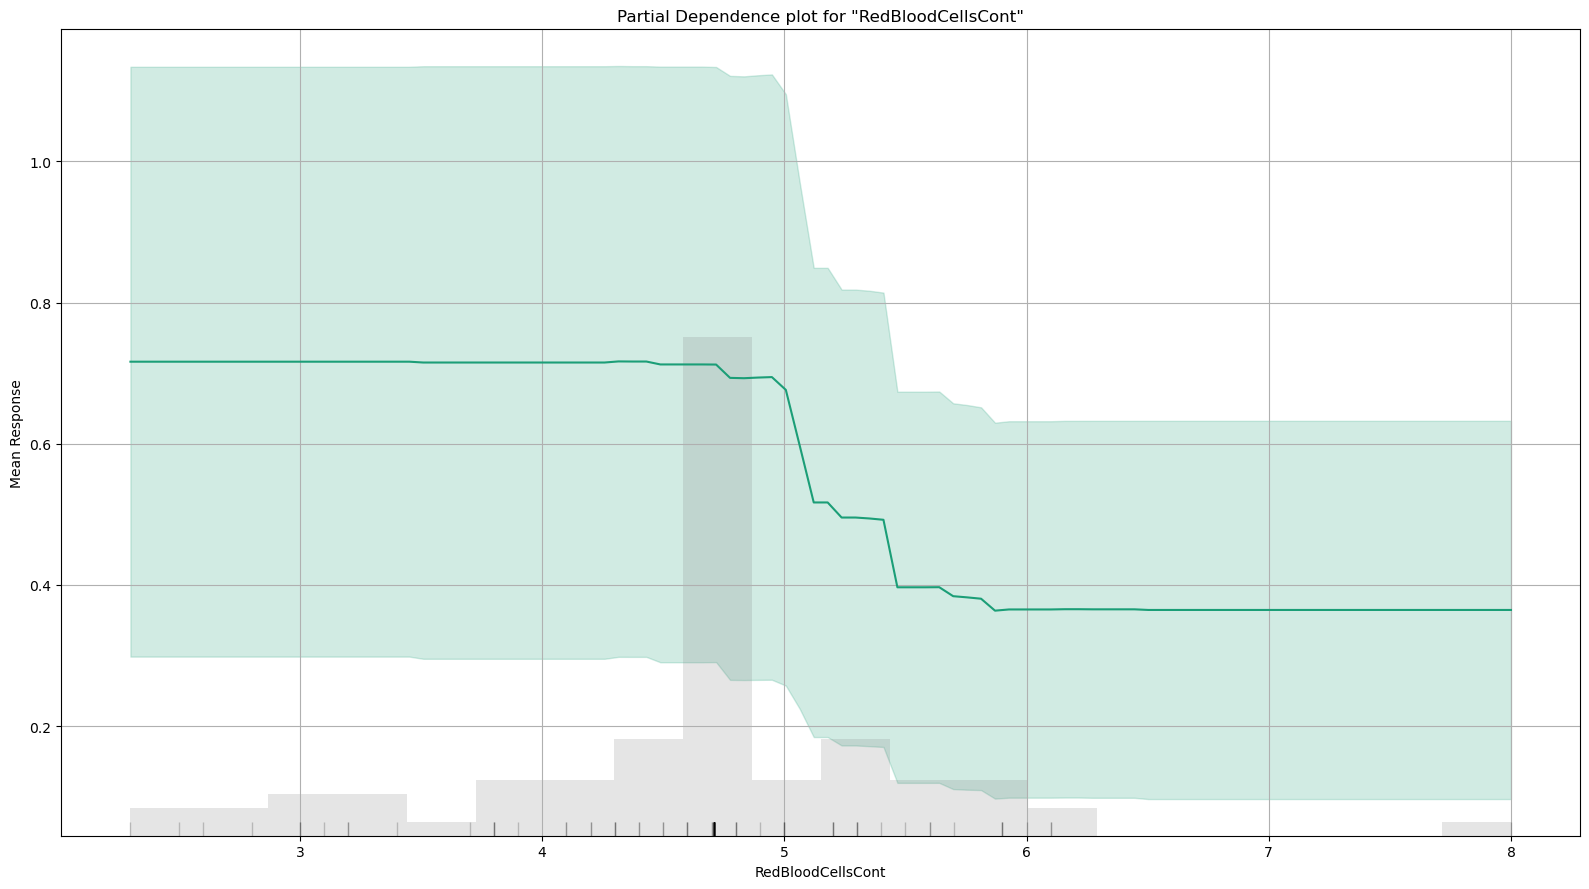

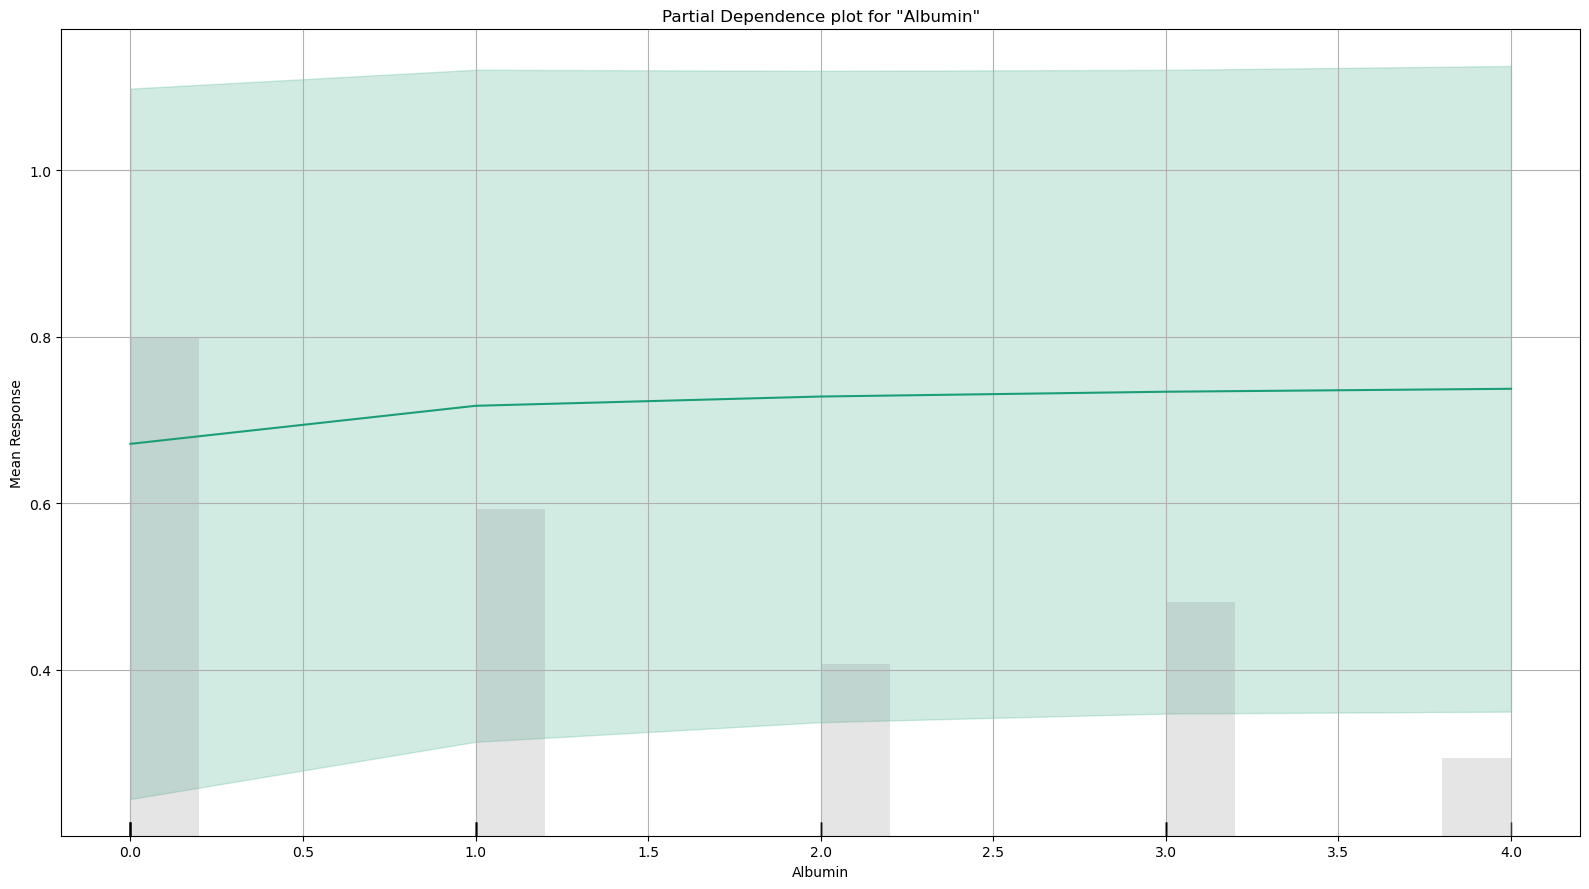

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

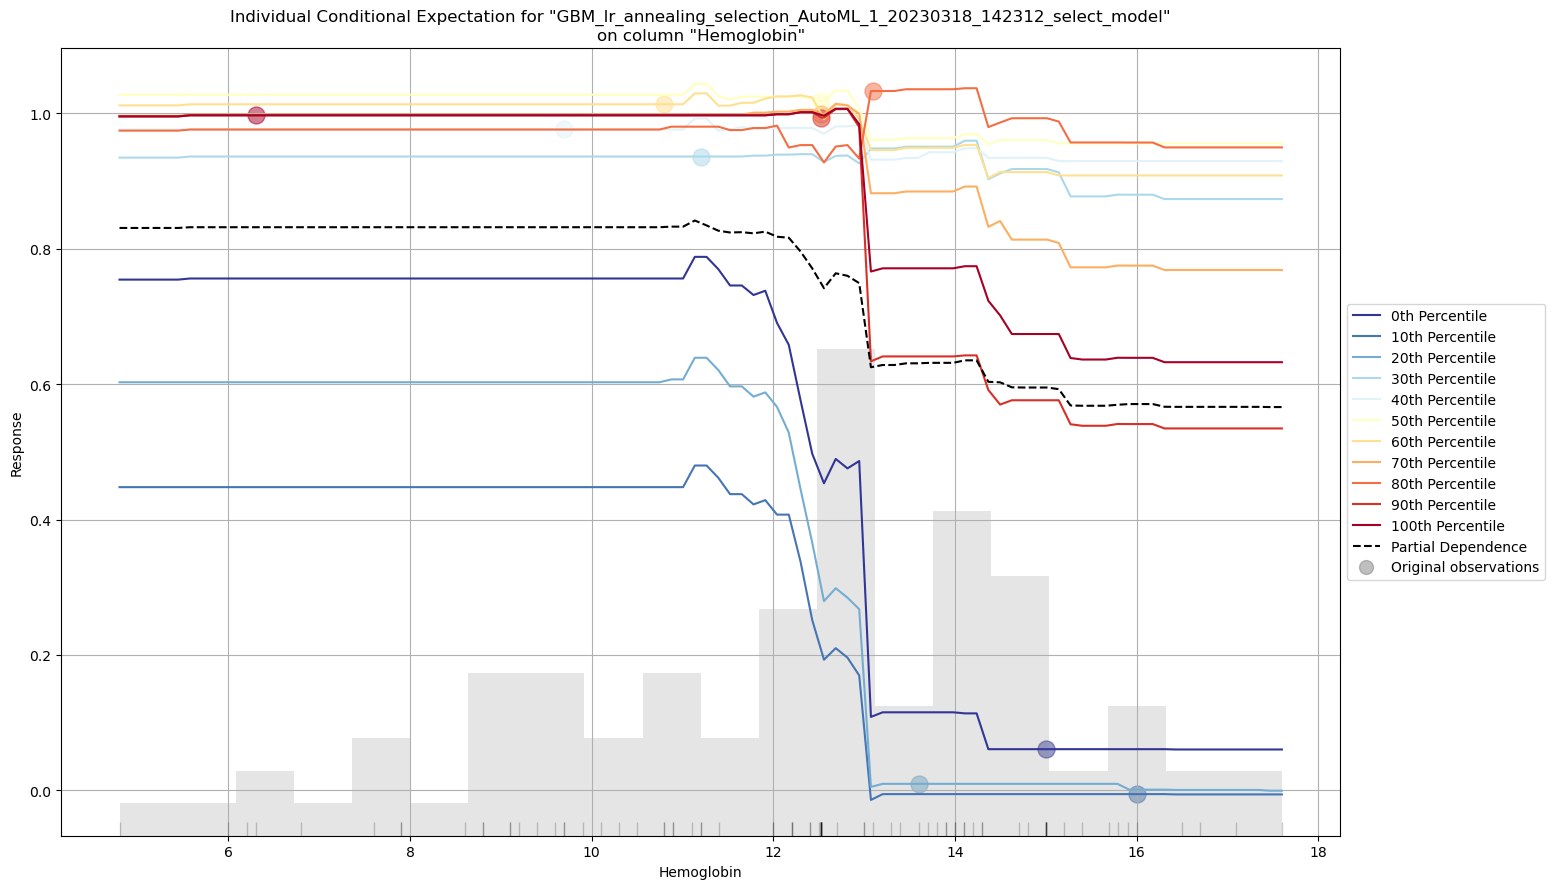

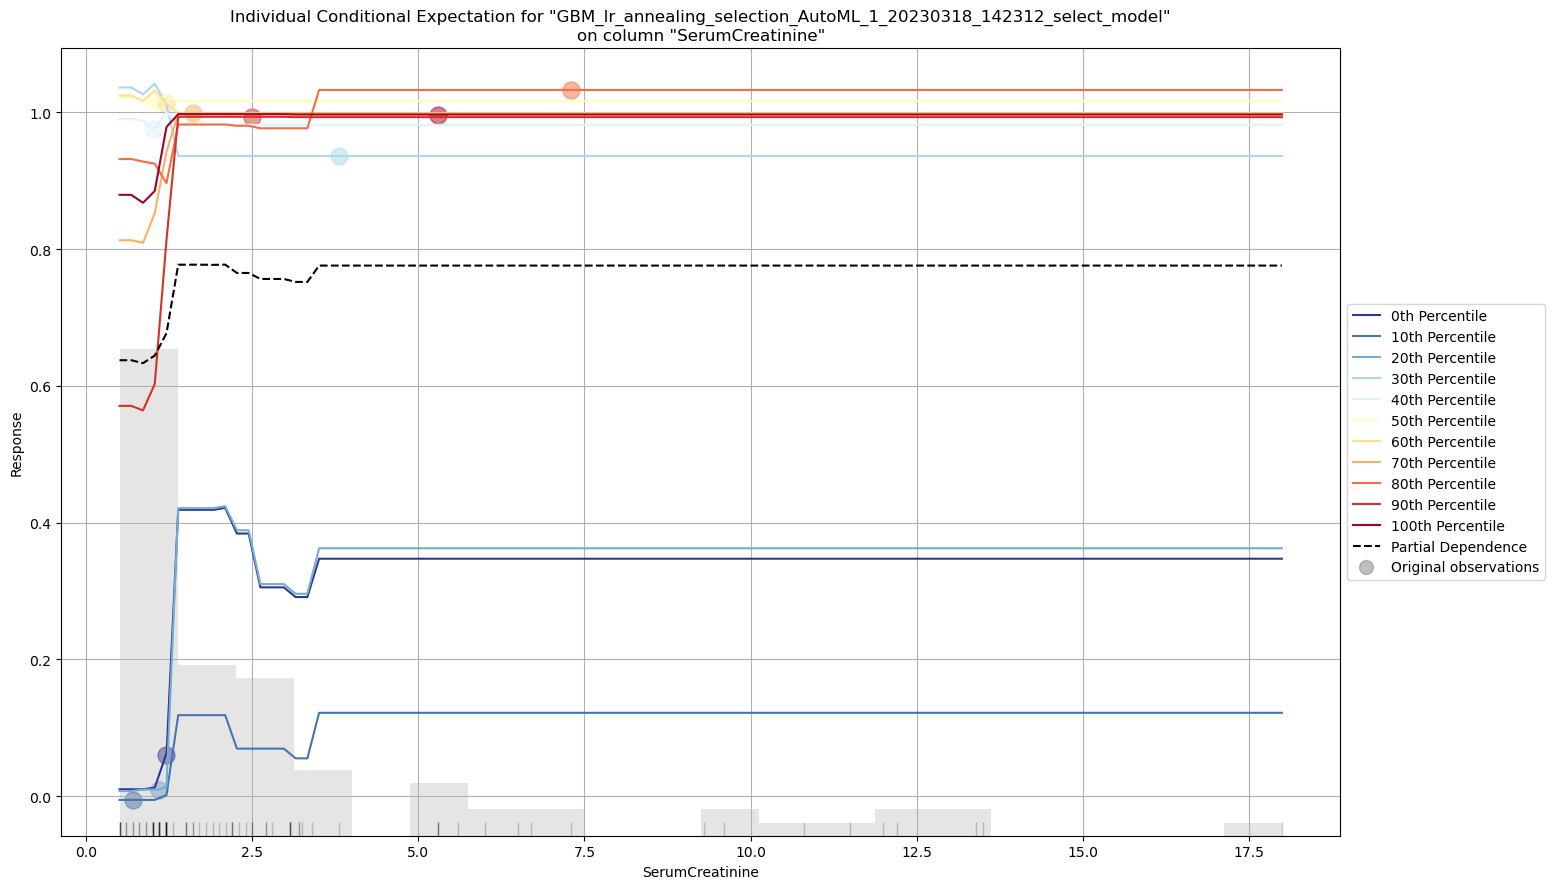

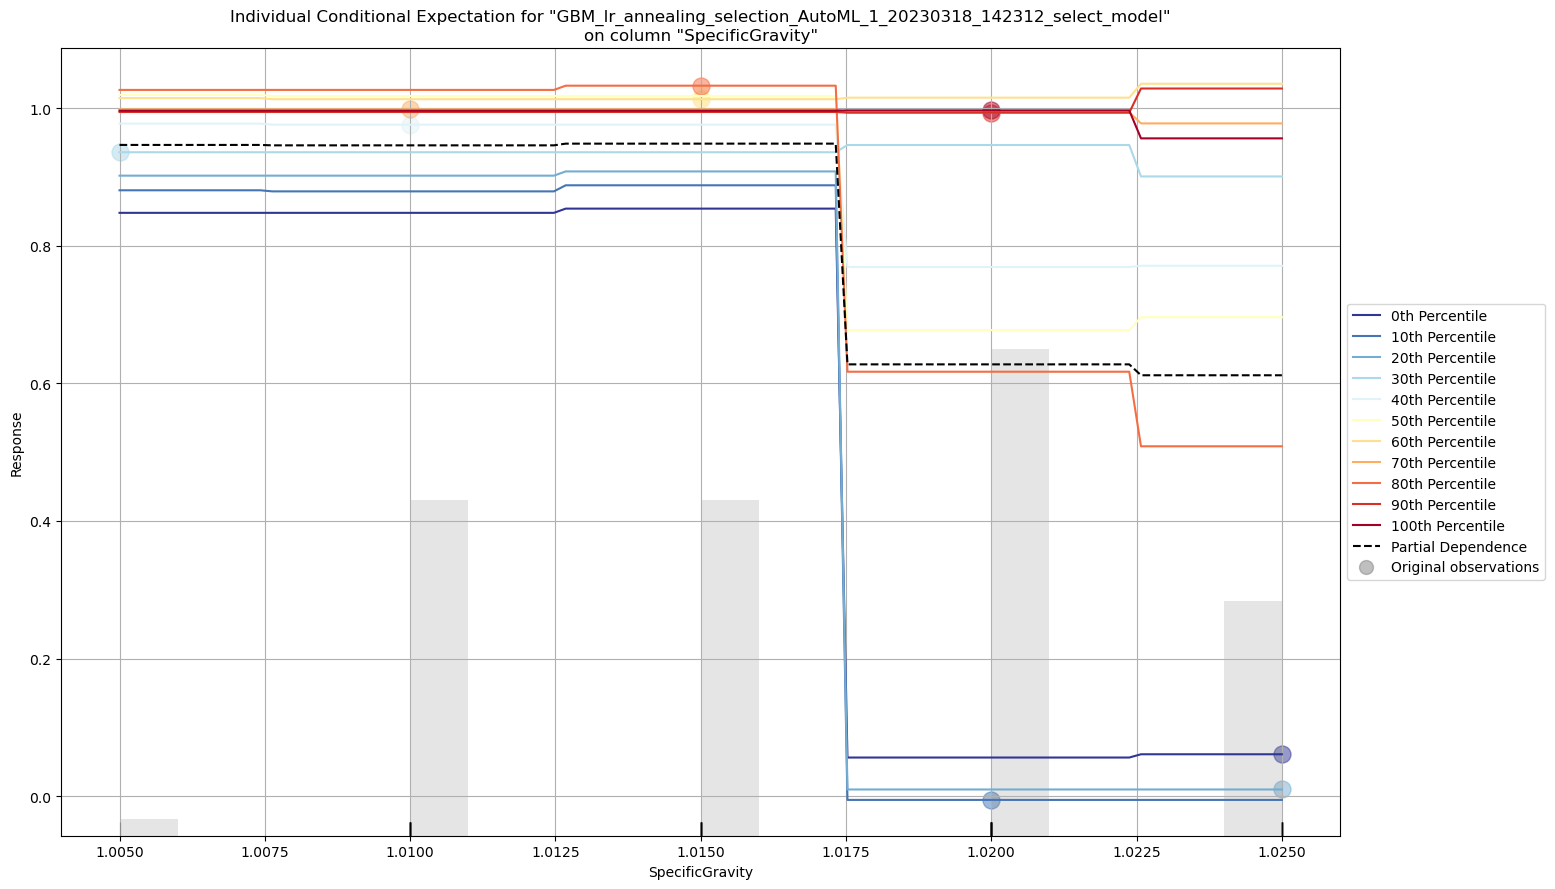

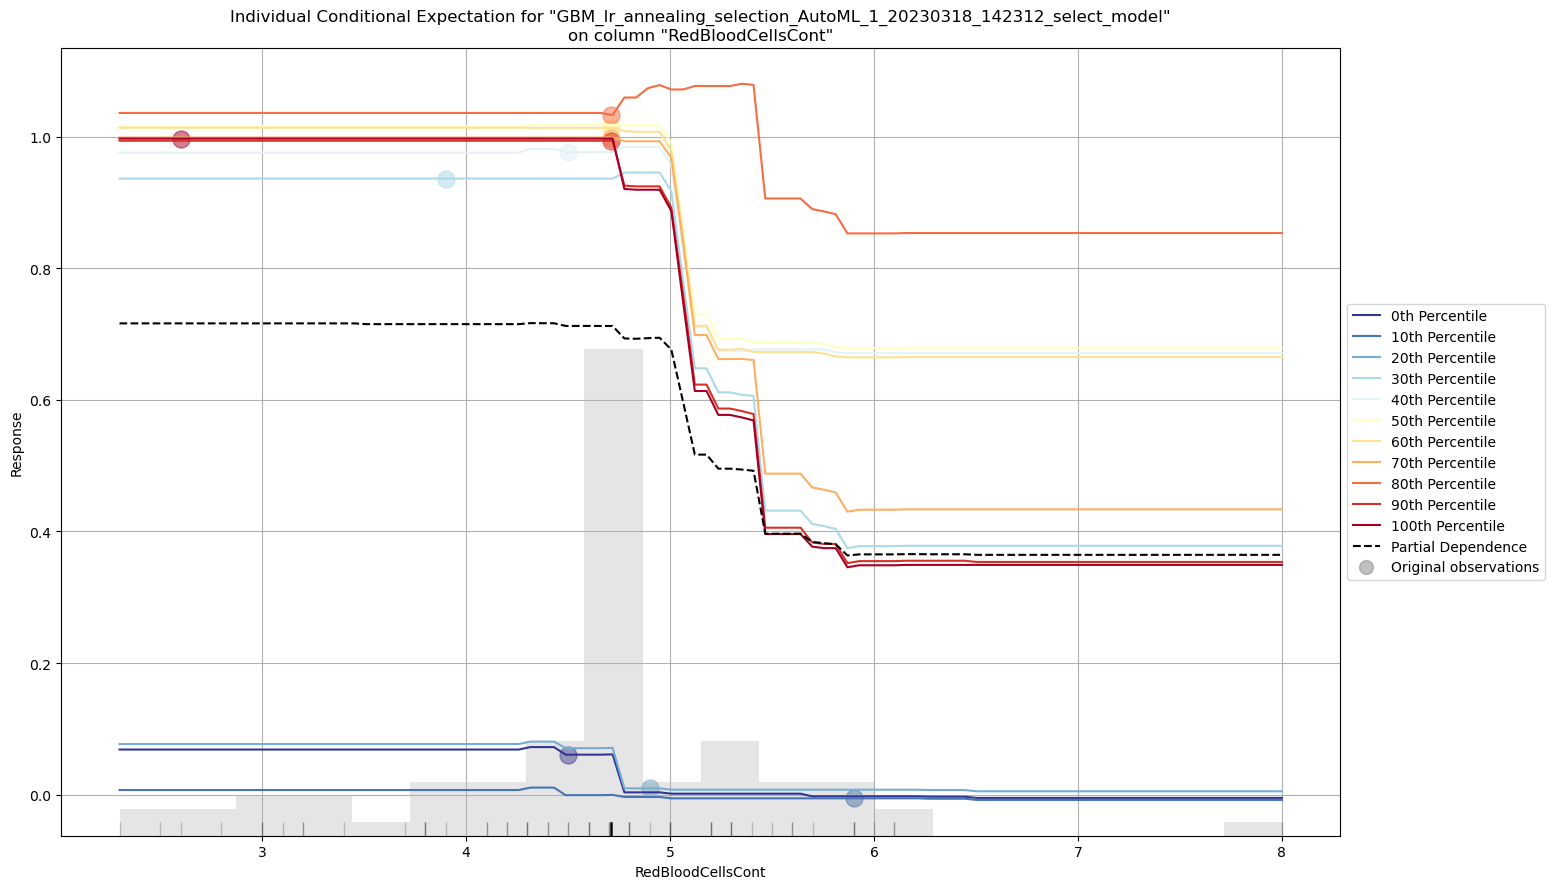

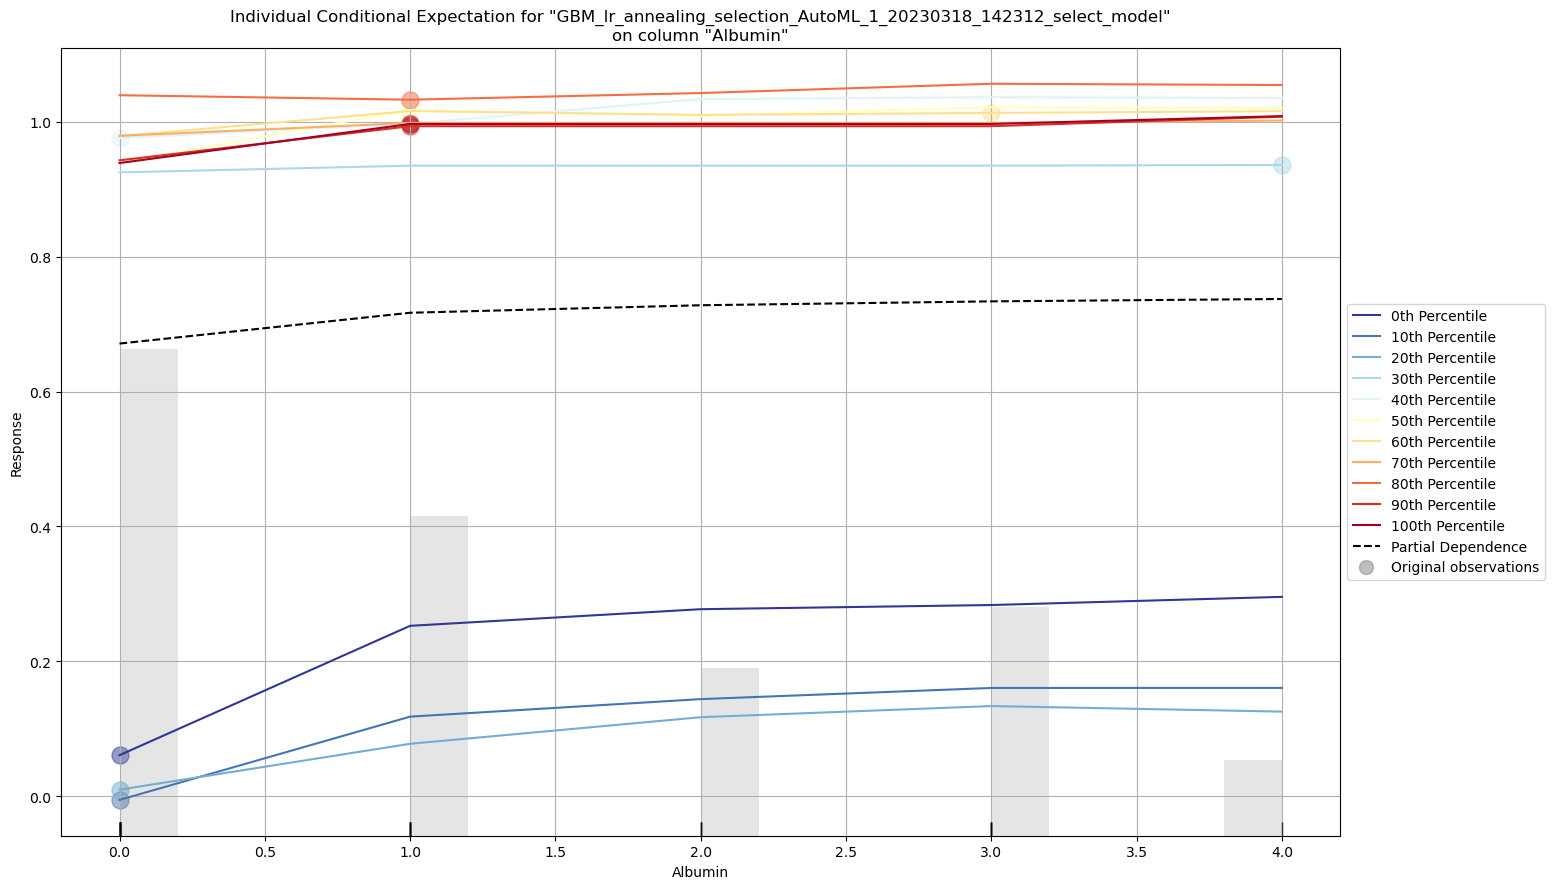

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [24]:
autoML_model.explain(df_test)  # AutoML Explainability


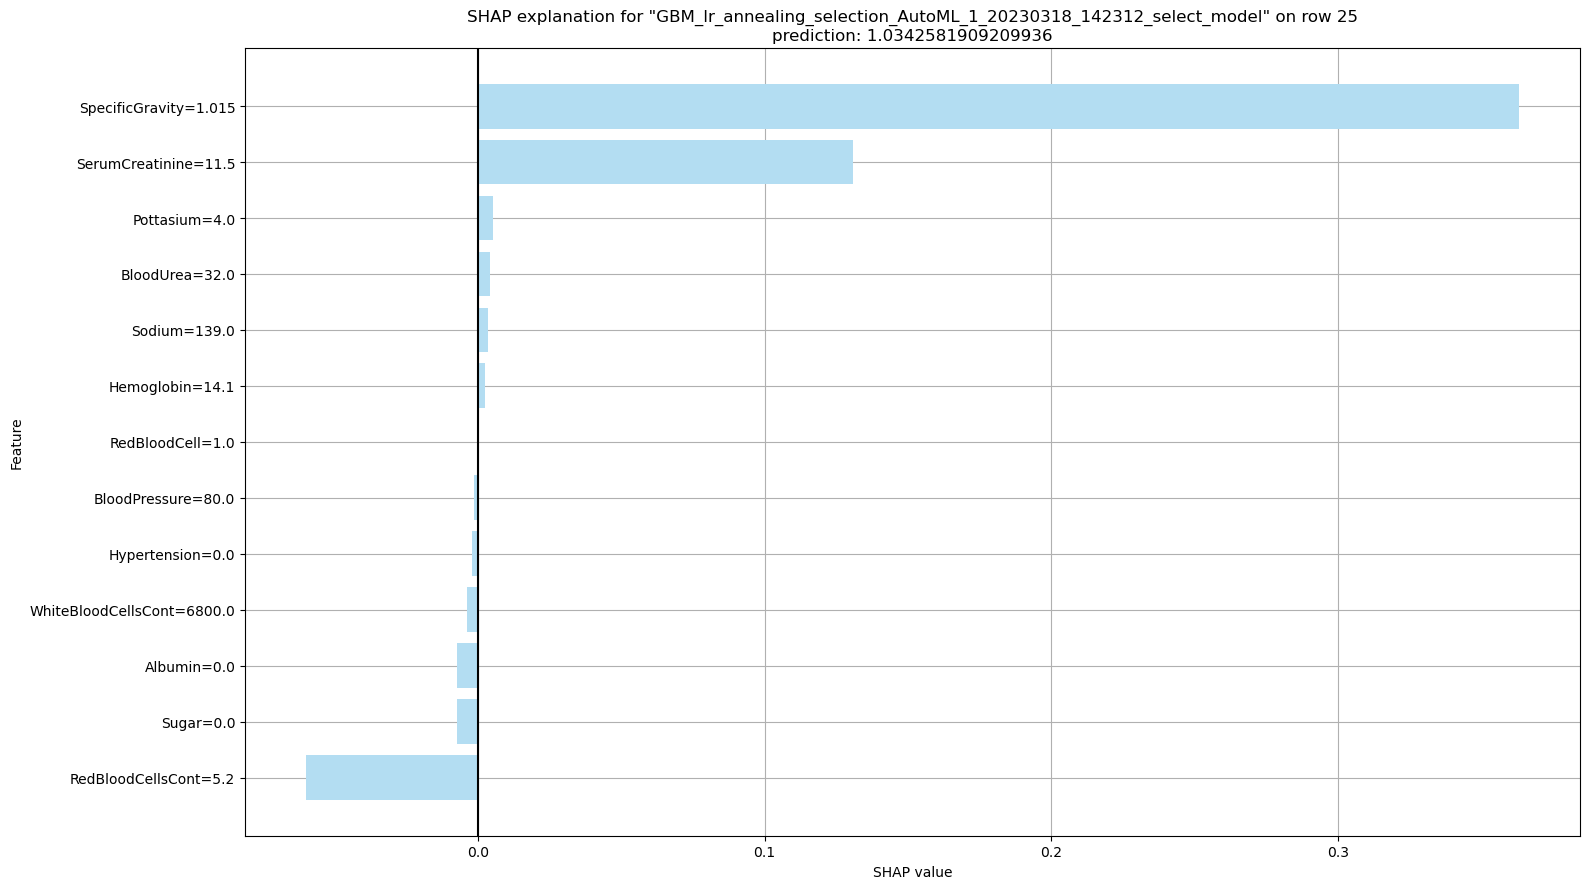

In [25]:

autoML_model.shap_explain_row_plot(
    autoML[1], 25
)  # Lets Analyze the 25th row in Test Data

# Interpreting Best Model for AutoML

### Residual Analysis
Here, we can see the striped lines of residuals, which is an artifact of having an integer value as a response value, instead of a real value. It can also be observed from the above graph that residuals are normally distributed. Visuals signify that residuals don't have heteroscedasticity since the plot has striped lines and there is no cone shaped residual plot.

### Variable Importance
In the variable importance plot we can observe that the plot replicates the results which we got from the Linear Model and Tree-Based Model above. That is Hemoglobin is the most important feature 

### SHAP Summary
From the SHAP summary diagram, we can interpret a few conclusions -

1. All the features are listed as per their importance in making the prediction, that is Specific Gravity is more significant followed by Hemoglobin, and so on. Hence, Potassium is the least significant predictor in our model.
2. The position on the SHAP value axis indicates the impact the feature has on the prediction either positive or negative. That is, the more the data point is away from the 0.0 shap value - the more its impact is. As we can see person having highest specific highest gravity is more prone to chronic kidney disease. The color of the dot represents (Red - High, Blue - Low) the impact of the value on the result. i.e. - Higher the specific gravity more will be the chances of person being prone to disease, a lower the Hemoglobin in the body results in high chances of disease, and so on. As we can see the distribution of red points in the Specific gravity and hemoglobin features are far more spread than the blue points.
3. From this visual, we can interpret that the chances of person getting disease increases as the Specific Gravity in blood increases. Let us analyze the distribution of SHAP values of this feature. As seen in the SHAP plot we can see that extreme values on both ends can have a significant effect in predicting the kidney disease. The advantage of SHAP analysis over normal feature importance is that we could visualize how the feature is affecting the target at different values. The standard methods tend to overestimate the importance of continuous or high-cardinality categorical variables.

### Partial Dependence Plot (PDP)
A partial dependence plot shows the marginal effect of a feature on the target(Chronic Kidney Disease in out dataset). It is achieved by keeping all other variables constant and changing the value of one variable to get its PDP.

For Interpretation purposes, let us pick up the two most important variables - Specific Gravity and Hemoglobin.

1. As we can see that when the rest of the variables are kept constant and a marginal change is made in Hemoglobin, we can see the mean response decreases between Hemoglobin levels of 12 to 18.

2. Similarly when the rest of the variables are kept constant and a marginal change is made in Specific Gravity we can observe the mean response of disease going down between the range of 1.0150 to 0.0175 . Hence, it can be interpreted that this range is deciding factor in the predicting disease.

The computation of partial dependence plots is intuitive: The partial dependence function at a particular feature value represents the average prediction if we force all data points to assume that feature value.

### ICE (Individual Conditional Expectation) Plot

ICE plot is similar to what we did in the PDP plot, but the fundamental difference between the two methods is that the PDP plot focuses on the average effect of a feature and does not focus on a specific instance. ICE plot comes in rescue to address this drawback of the PDP plot where the outputs from all instances are considered instead of an average value.

Let us go back to the Hemoglobin and Specific Gravity, as we interpreted in PDP the person having diseases decreases when Hemoglobin and Specific Gravity value is between 12 to 18 and 1.0150 to 0.0175 respectively. But is this true for every individual in the dataset? ICE plot has an answer to this question.

Each line in an ICE plot represents the predicted value of the response variable for a single instance as the predictor variable changes. By looking at these lines together, you can get a sense of how the relationship between the predictor and response variables varies across different instances in the dataset.

As we can see in the ICE plot above the Chronic Kidney Disease parameter(target variable) of a few instances in data set(0th percentile instance) is constant first and decreases in this range while the target variable of a few instances doesn't change much(100th Percentile Instance).

Individual conditional expectation curves are even more intuitive to understand than partial dependence plots. One line represents the predictions for one instance if we vary the feature of interest.


# SHAP Analysis for Linear and Tree-Based Models

__SHAP (SHapley Additive exPlanations)__ is a method for interpreting the output of machine learning models, and it provides insights into the contribution of each feature to the model's prediction for a particular instance. SHAP values measure the impact of each feature on the model's output for a particular instance, and they provide a unified measure of feature importance that is consistent across different models.

For __linear models__, SHAP values can be calculated using the coefficients of the model as written in code below. The SHAP value for a particular feature is calculated as the product of the coefficient for that feature and the difference between the prediction with that feature included and the prediction with that feature excluded.

For __tree-based models__, SHAP values can be calculated using the tree structure and the feature values of a particular instance. The SHAP value for a particular feature is calculated as the difference between the average prediction of the model with that feature present in the tree and the average prediction of the model with that feature absent in the tree, over all possible subsets of features.

Permutation explainer: 361it [00:25,  8.93it/s]                                                                        


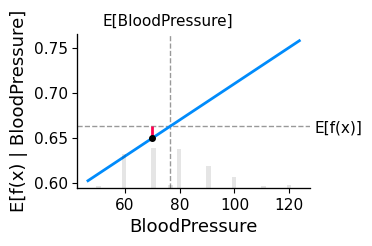

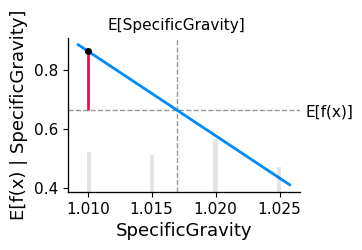

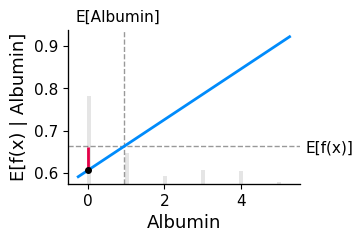

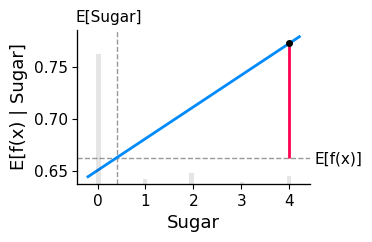

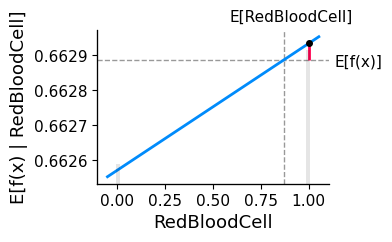

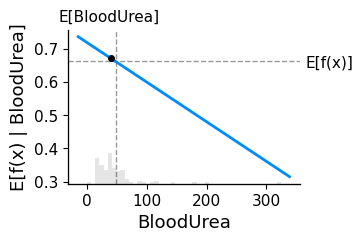

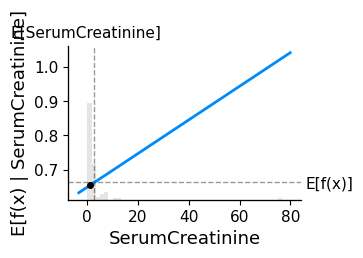

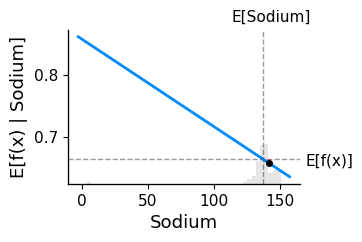

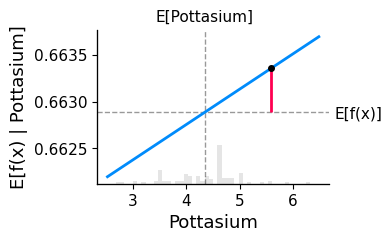

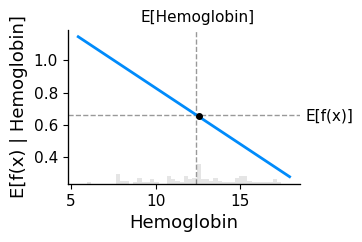

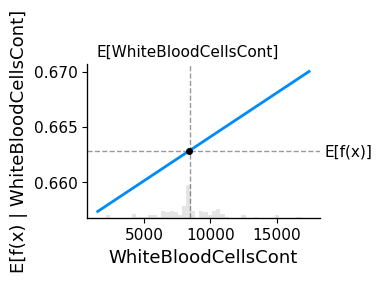

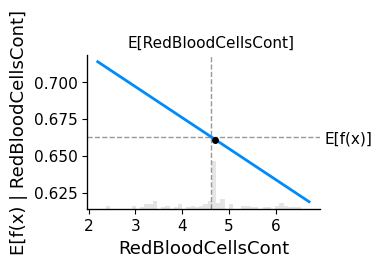

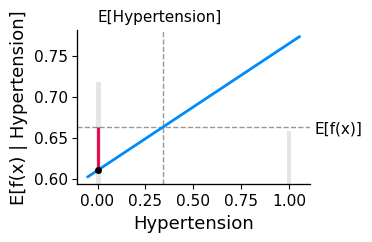

In [26]:
import matplotlib.pyplot as plt

#This code is performing a SHAP partial dependence plot for a linear model
linear_explainer = shap.Explainer(linear_model.predict, x_train_100)
linear_shap_values = linear_explainer(x_train)

for i in x_train.columns:
    # make a standard partial dependence plot
    sample_ind = 31
    fig, ax = plt.subplots(figsize=(3,2)) # Create a new figure with the desired size
    shap.partial_dependence_plot(
        i,
        linear_model.predict,
        x_train_100,
        model_expected_value=True,
        feature_expected_value=True,
        ice=False,
        shap_values=linear_shap_values[sample_ind : sample_ind + 1, :],
        ax=ax # Pass the axes of the new figure to the function
    )


## Analysis:
1. The above code generates a partial dependence plot for each feature in the __x_train__ dataframe using the SHAP values calculated for the linear model. The resulting plots show the effect of each feature on the model's prediction for a single sample(I have taken sample number 31)

2. Since the focus is on generating partial dependence plots for each feature to visualize the marginal effect of each feature on the model's prediction, ICE plots are not necessary and can be computationally expensive to generate.

3. Here the x-axis is the feature and the y-axis is the output as we vary the feature. The grey histogram is the distribution of variables in the dataset and the cross made by E[Feature], E[f(x)] is the expected values.

4. Let us take a feature of Blood Pressure
     -- For the linear model the cross is made at approx E[f(x)] 0.667(Approx)
     
5. So as the Blood Pressure increases the expected value also increases

6. The red line on the plot - When we give a sample as an input (sample_ind = 31) as an input to check the output. By plotting this we can see the difference between the model output from the expected value.

Permutation explainer: 361it [00:26,  7.03it/s]                                                                        


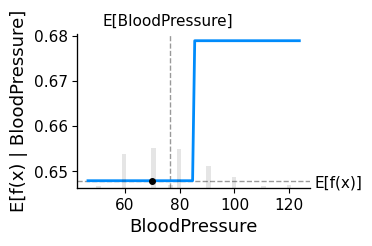

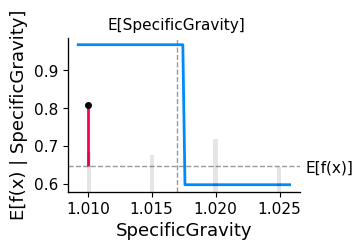

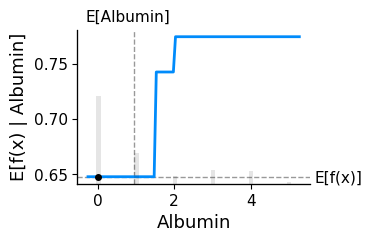

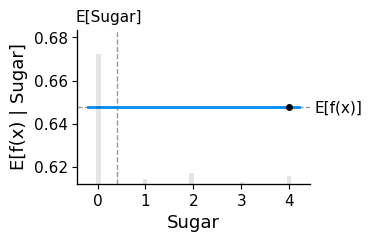

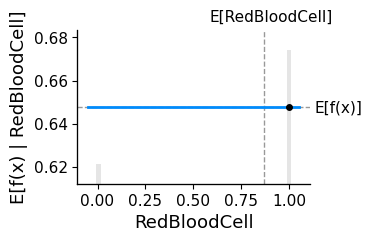

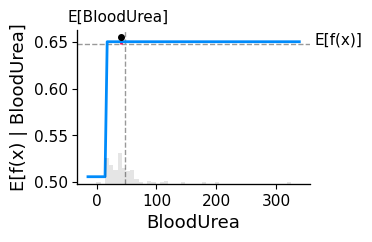

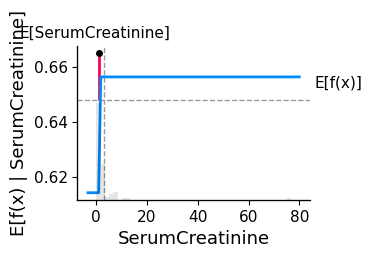

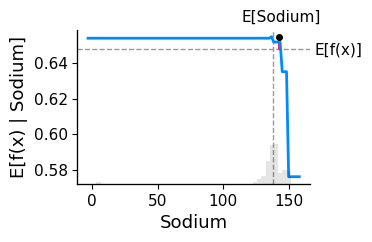

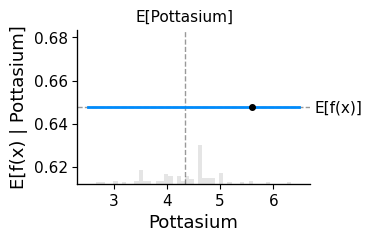

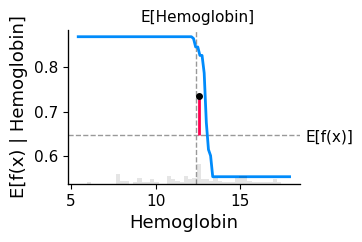

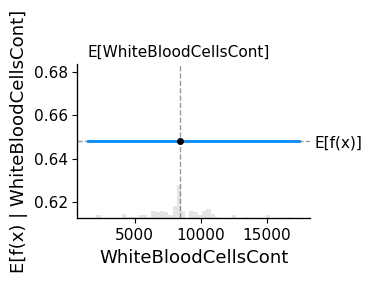

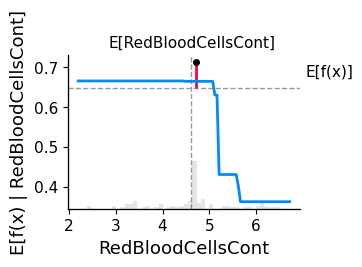

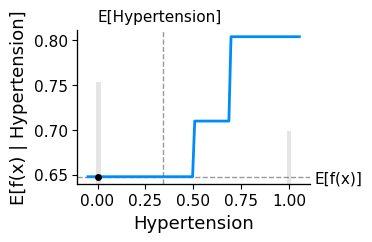

In [27]:

#This code is performing a SHAP partial dependence plot for a Tree Model
tree_explainer = shap.Explainer(tree_model.predict, x_train_100)
tree_shap_values = tree_explainer(x_train)
for i in x_train.columns:
    # make a standard partial dependence plot
    sample_ind = 31
    fig, ax = plt.subplots(figsize=(3,2)) # Create a new figure with the desired size
    shap.partial_dependence_plot(
        i,
        tree_model.predict,
        x_train_100,
        model_expected_value=True,
        feature_expected_value=True,
        ice=False,
        shap_values=tree_shap_values[sample_ind : sample_ind + 1, :],
        ax=ax
    )


## Analysis
1. This code generates a partial dependence plot for each feature in the __x_train__ dataframe using the SHAP values calculated for the tree-based model. The resulting plots show the effect of each feature on the model's prediction for a single sample.

2. Let us take a feature of Blood Pressure --For Tree-based model the cross is made at approx E[f(x)] 0.633(Aprox)
3. So as the Blood Pressure increases the expected value also increases

4. The red line on the plot - When we give a sample as an input (sample_ind = 31) as an input to check the output. By plotting this we can see the difference between the model output from the expected value.


__Note:__The tree_model object is assumed to be a tree-based model, such as a decision tree, random forest, or gradient boosting machine. Tree-based models have a different internal structure compared to linear models, and SHAP values for tree-based models are calculated differently. The tree_explainer object is designed to handle these differences and calculate SHAP values for tree-based models.

## Interpreting SHAP Feature Importance Plot for Linear and Tree-based model

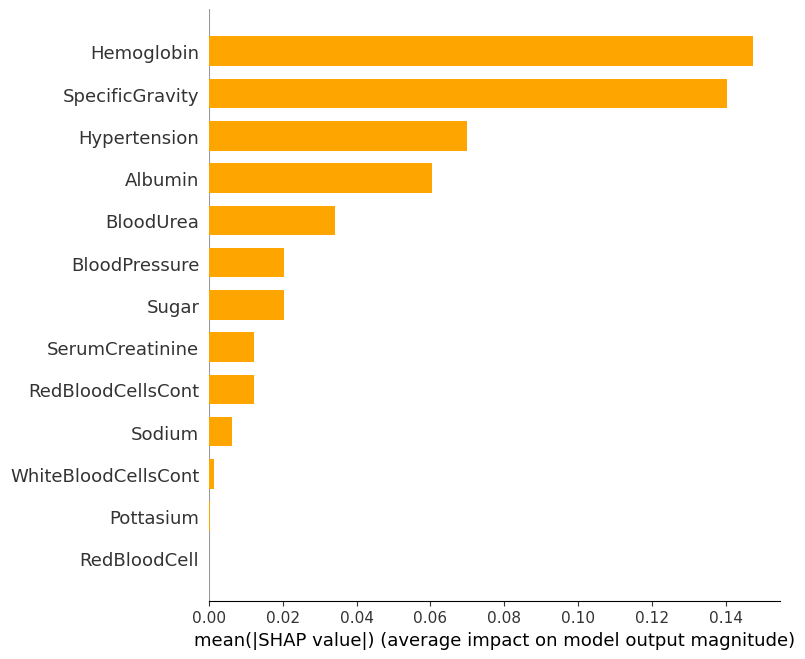

In [28]:

# SHAP variable importance for a Linear Model
shap.summary_plot(linear_shap_values, x_train, plot_type="bar", color="orange")

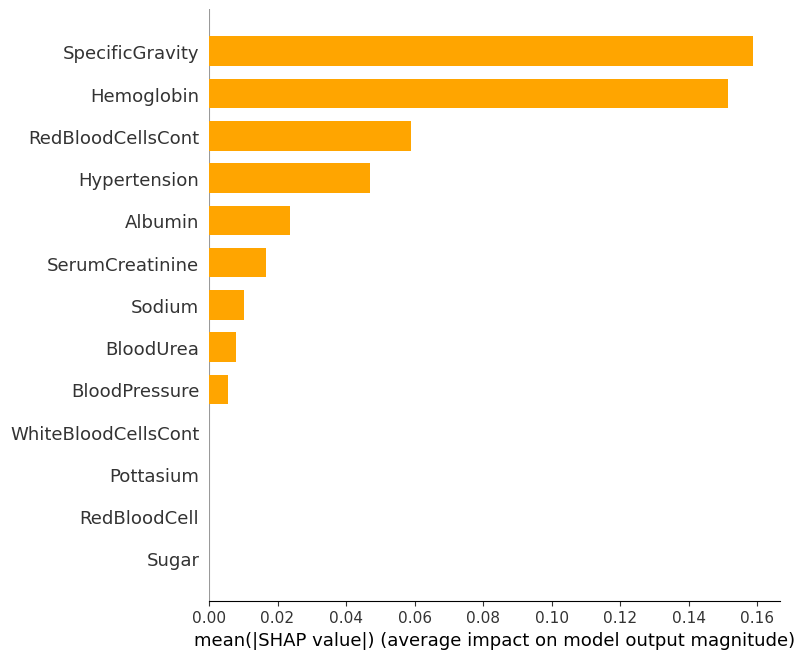

In [29]:

# SHAP variable importance for Tree based model
shap.summary_plot(tree_shap_values, x_train, plot_type="bar", color="orange")

## Observations:
A variable importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power. The shap.summary_plot function with plot_type=”bar” lets you produce the variable importance plot.

## Interpret the summary plot for the Linear and Tree-based model

The SHAP value plot can show the positive and negative relationships of the predictors with the target variable. The code produces the following plot:

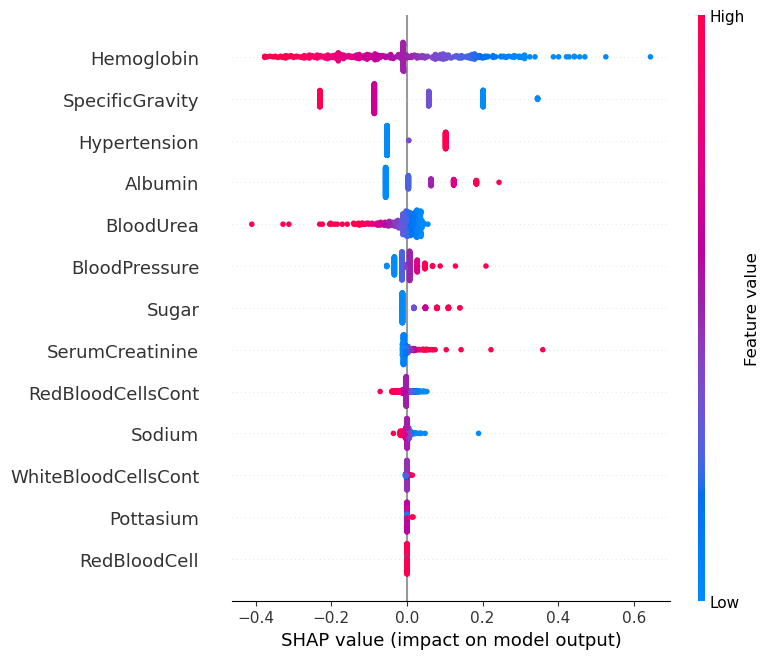

In [30]:

# SHAP summary for Linear Model
shap.summary_plot(linear_shap_values, x_train)

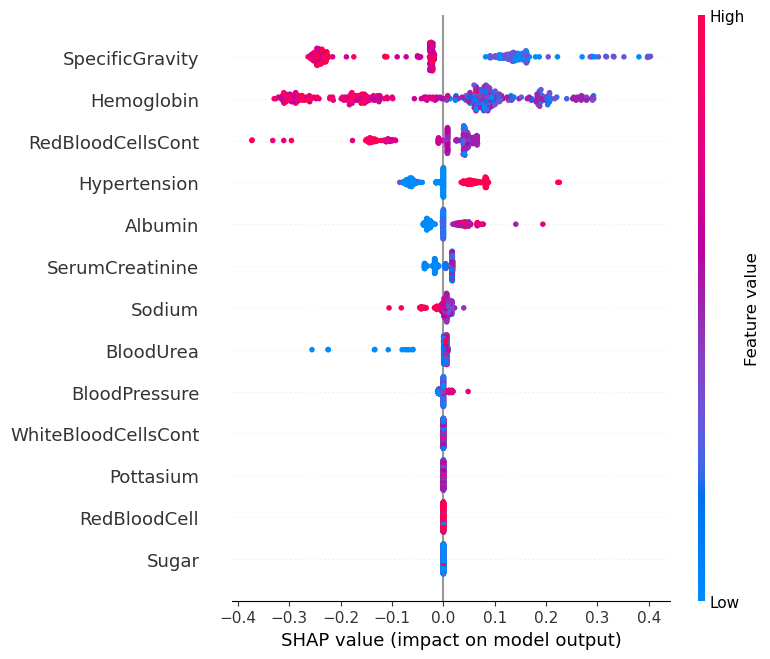

In [31]:

# SHAP summary for Tree Model
shap.summary_plot(tree_shap_values, x_train)

## Observations:
The SHAP value plot can show the positive and negative relationships of the predictors with the target variable. 
The code shap.summary_plot(shap_values, X_train)produces the following plot:

This plot is made of all the dots in the train data. It delivers the following information:

1. __Feature importance:__ Variables are ranked in descending order.
2. __Impact:__ The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
3. __Original value:__ Color shows whether that variable is high (in red) or low (in blue) for that observation.
4. __Correlation:__ A high level of the “Hemoglobin” content has a low and positive impact on the target variable(in our case its chronic kidney disease).Which means that the person with high levels of Hemoglobin is less prone to kidney disease. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “Hypertension” is positively correlated with the target variable. Which means that the high levels of hyper tension will have high chances of person prone to disease

## Interpreting SHAP dependence plot for Linear and Tree-based model

Lets visuilize SHAP dependence plot. A partial dependence plot shows the marginal effect of one or two features on the predicted outcome of a machine learning model . It tells whether the relationship between the target and a feature is linear, monotonic or more complex. 

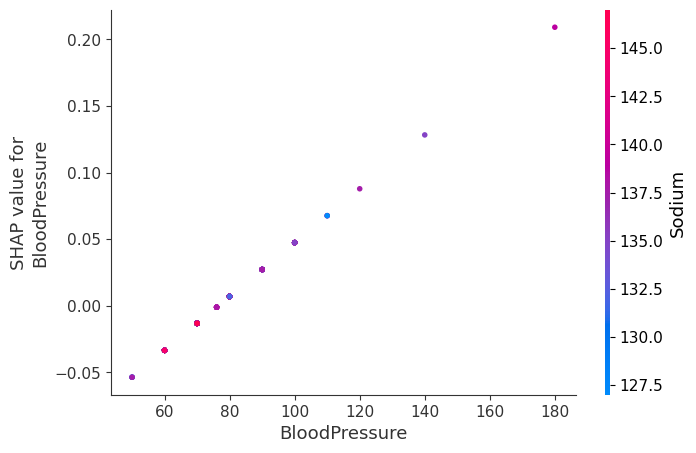

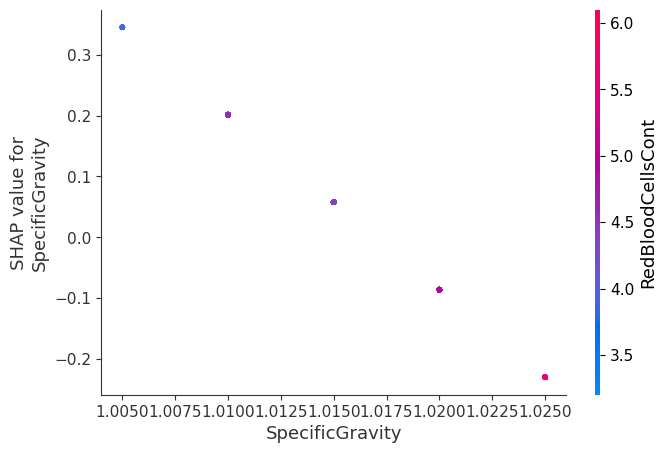

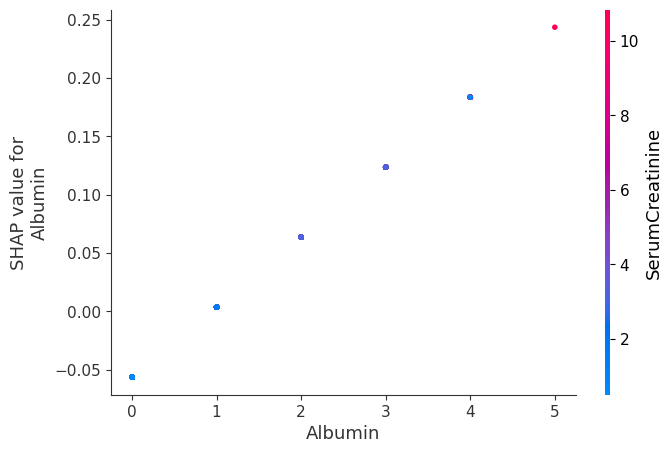

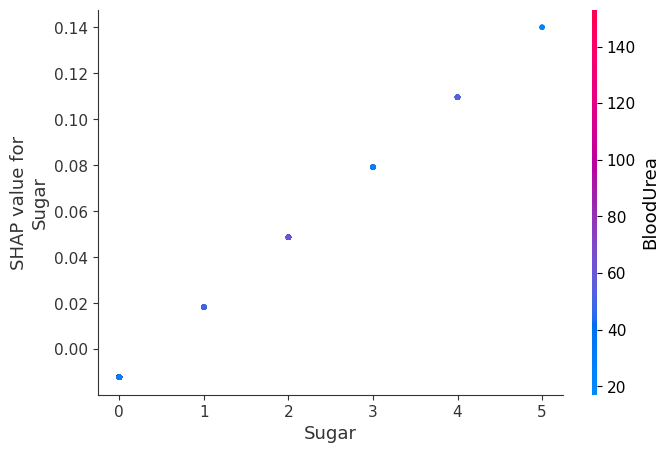

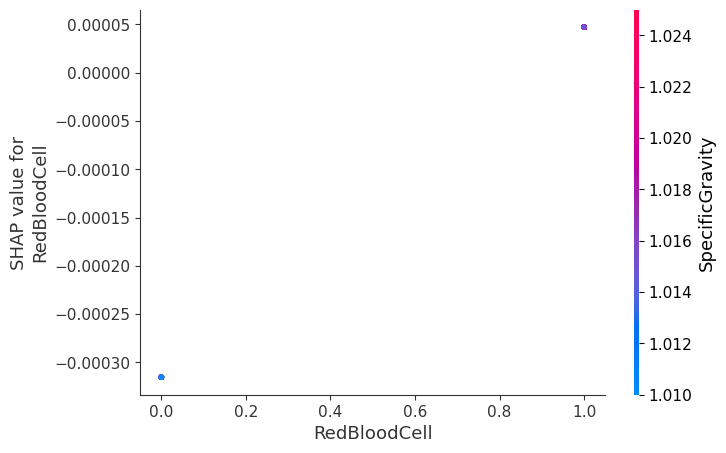

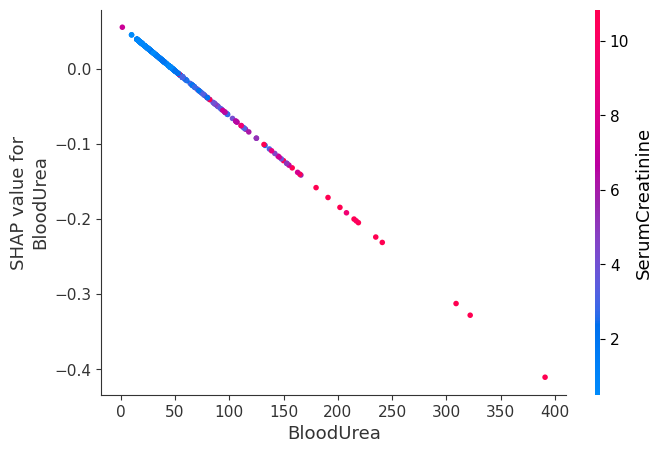

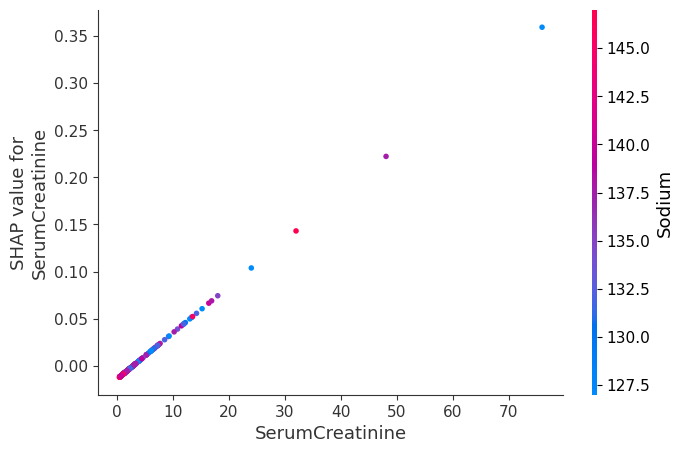

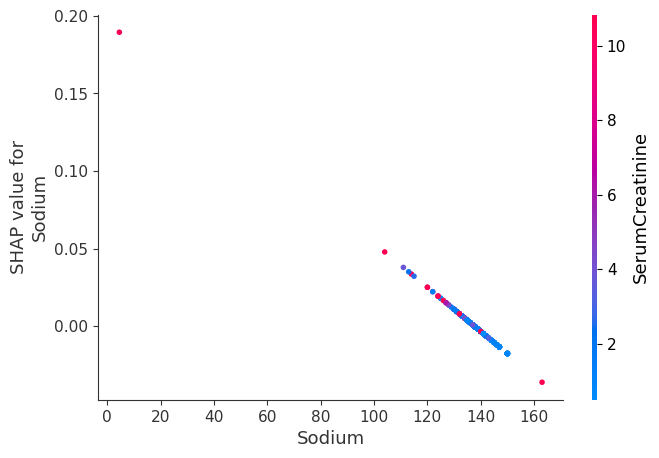

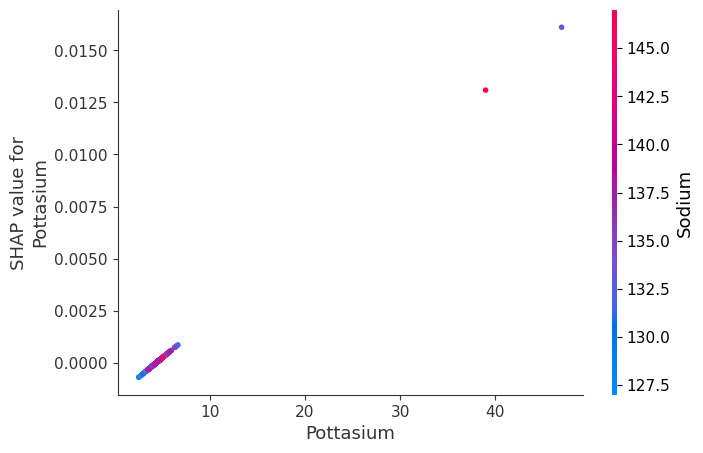

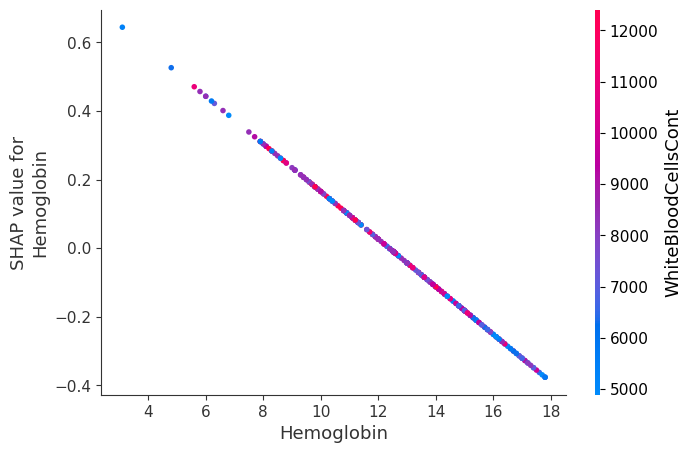

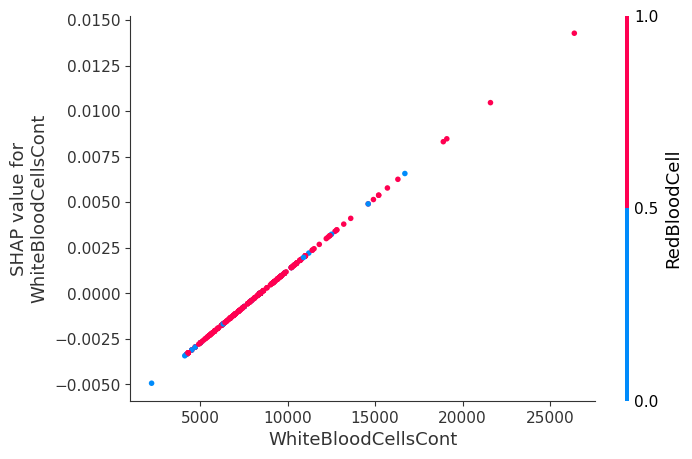

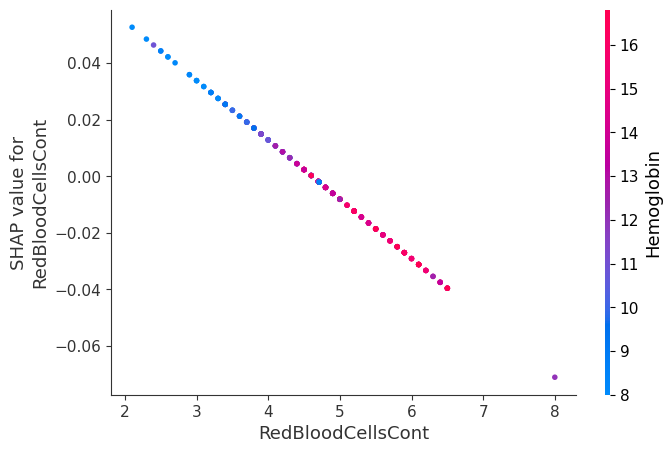

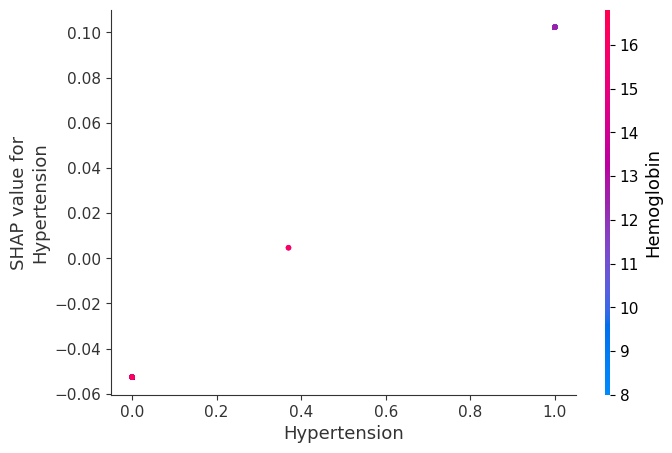

In [32]:

# SHAP partial dependence plot for linear model
for i in x_train.columns:
    shap.dependence_plot(i, linear_shap_values.values, x_train)

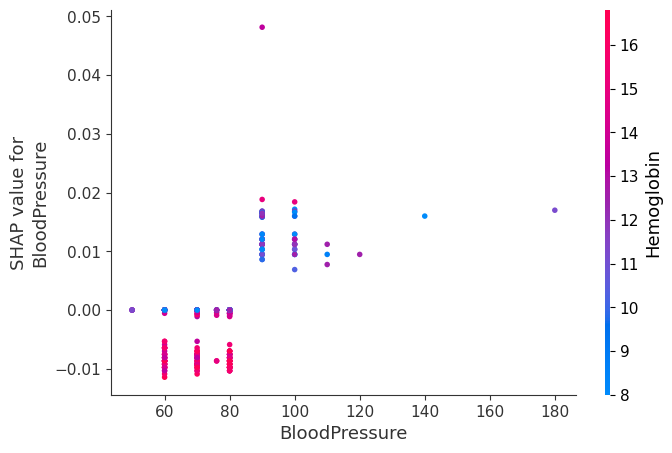

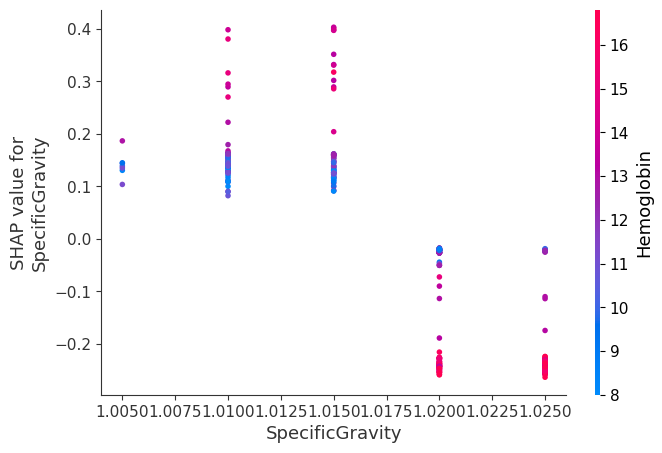

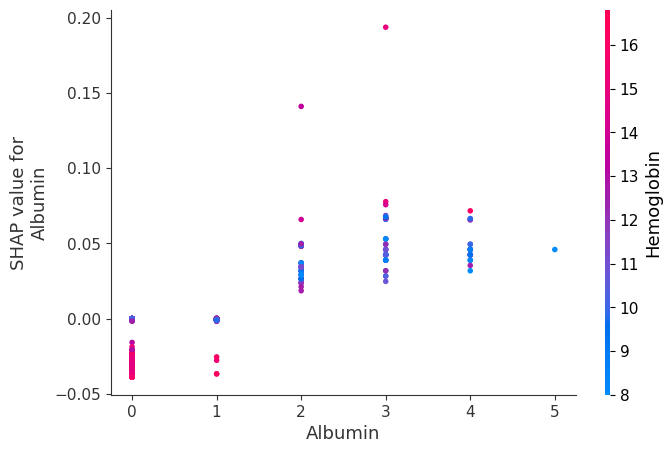

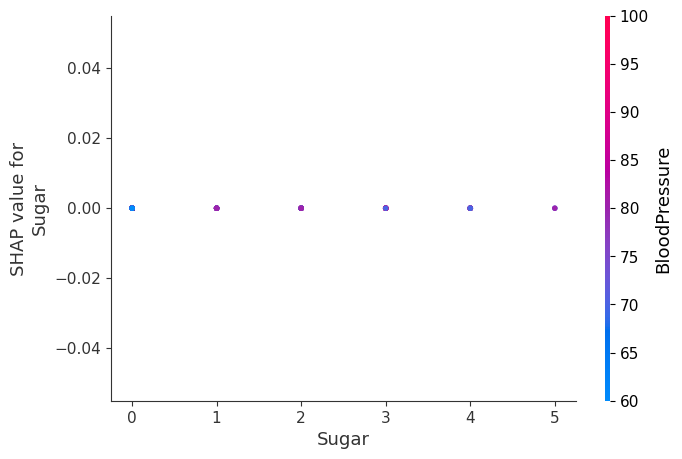

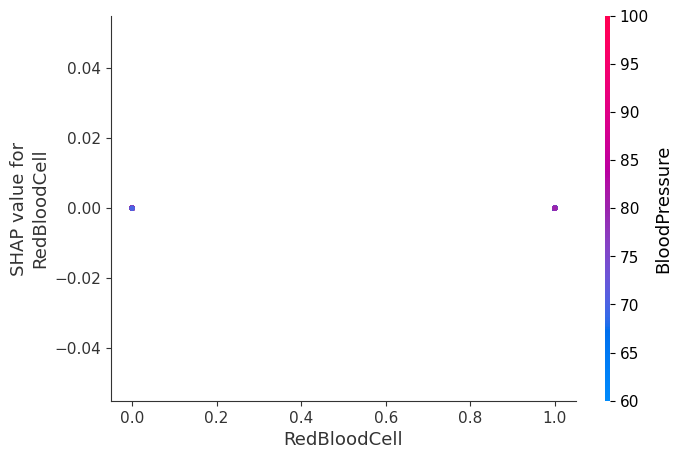

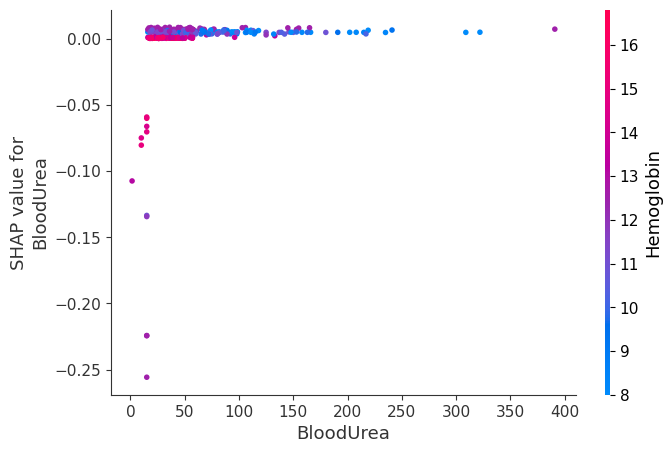

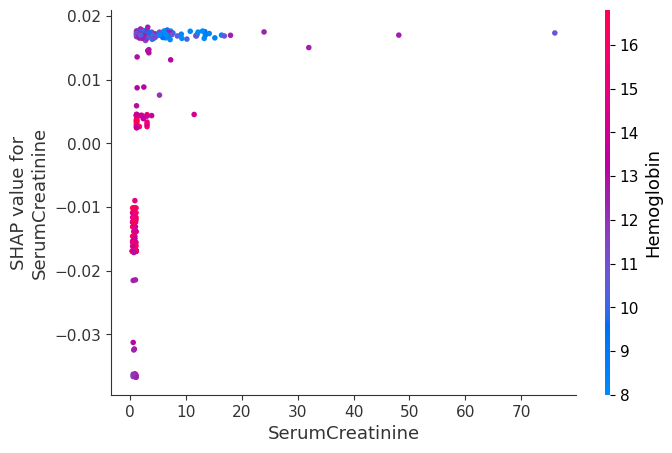

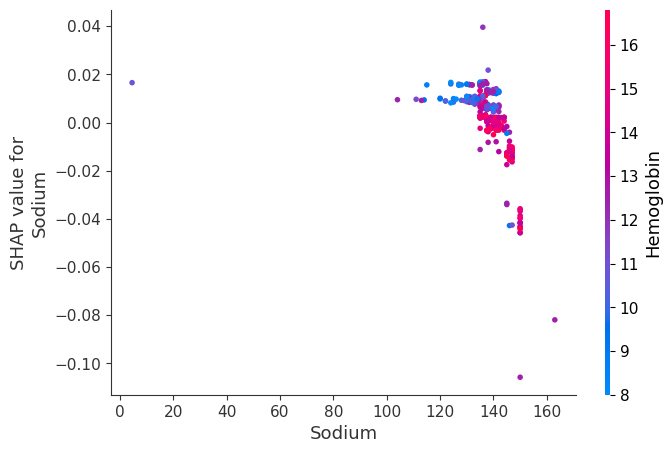

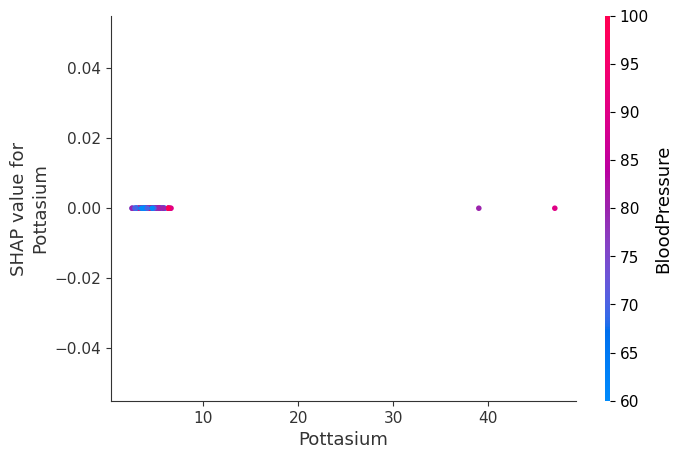

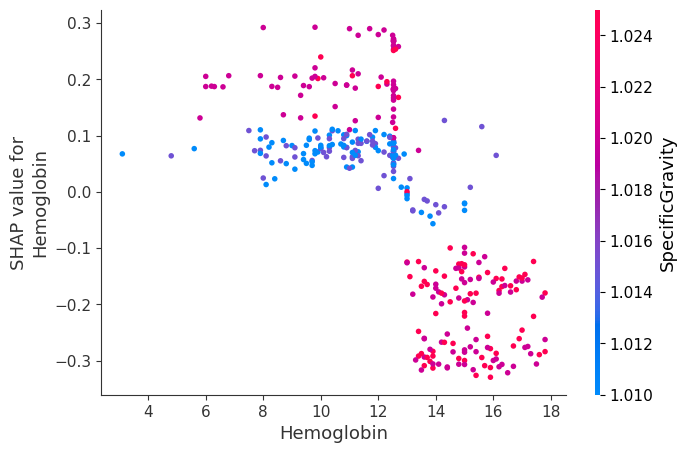

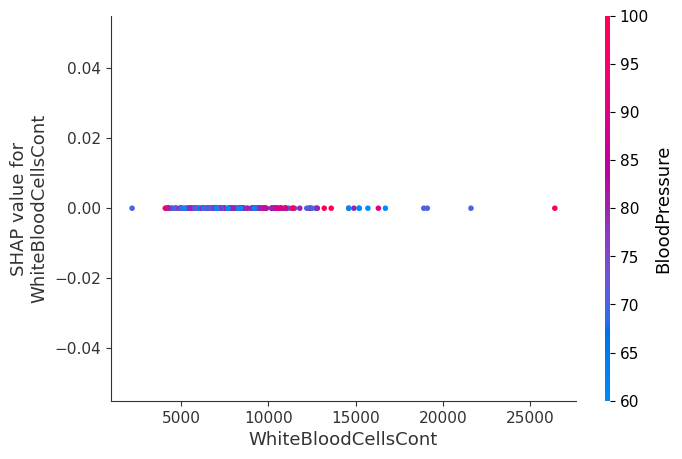

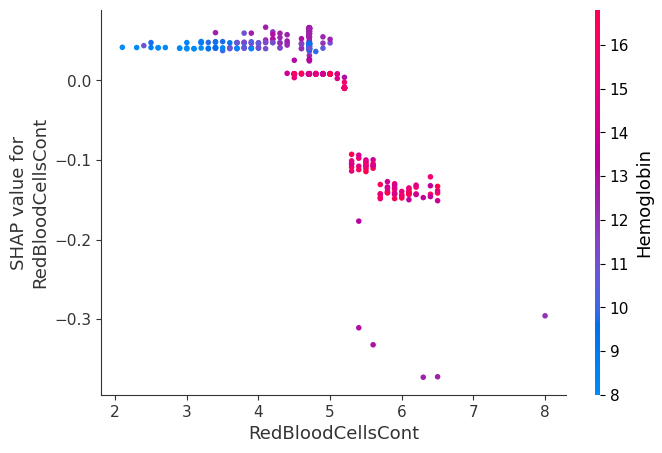

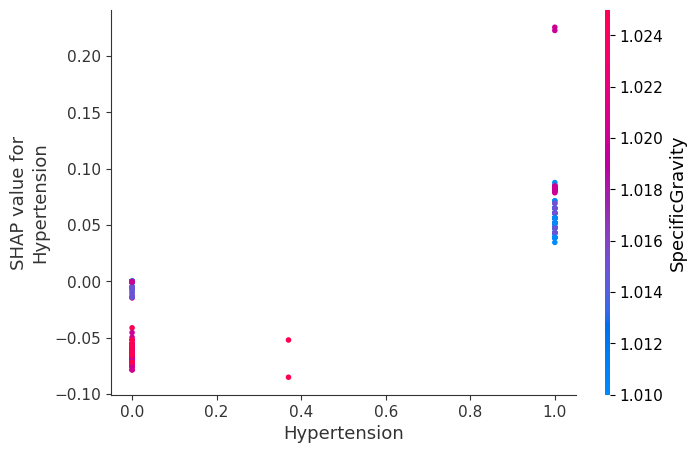

In [33]:

# SHAP partial dependence plot for a tree based model
for i in x_train.columns:
    shap.dependence_plot(i, tree_shap_values.values, x_train)

## Observations
- To create a dependence plot, we only need single line of code: shap.dependence_plot(“Feature”, shap_values, X_train). Here I have iterated over all 14 features and plotted the graphs. 
- The function here automatically includes another variable that your chosen variable interacts most with.
- The first plot show there is an approximately linear and positive trend between “Blood Presssure” and the target variable, and “Blood Pressure” interacts with “Hypertension” frequently.
- Suppose if we want to know “Specific Gravity”, as well as the variable that it interacts with the most, you can do shap.dependence_plot(“Specific Gravity”, shap_values, X_train). The output will be same as my 2nd figure of linear model.
- The 2nd plots show there exists an approximately linear but negative relationship between “Specific Gravity” and the target variable. 



## Force Plot SHAP analysis

In [34]:

# Get the predictions and put them with the test data.
X_output = x_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,33,50) # Every 50 rows
S = X_output.iloc[random_picks]
S

BloodPressure  SpecificGravity  Albumin  Sugar  RedBloodCell  BloodUrea  \
280           80.0             1.02      1.0    0.0           1.0       33.0   

     SerumCreatinine  Sodium  Pottasium  Hemoglobin  WhiteBloodCellsCont  \
280              0.9   144.0        4.5        13.3               8100.0   

     RedBloodCellsCont  Hypertension  predict  
280                5.2           0.0  -424.32

In [35]:

# Force Plot of Tree Based Model
explainerModel = shap.TreeExplainer(tree_model)
shap_values_Model = explainerModel.shap_values(X_output)


def shap_plot_tree(j):
    p = shap.force_plot(
        explainerModel.expected_value, shap_values_Model[j], X_output.iloc[[j]],matplotlib= True
    )
    return p

### Interpret Observation 1

Let me walk you through the above code step by step. The shap.force_plot() takes three values: 
- (i) the base value (explainerModel.expected_value[0])
- (ii) the SHAP values (shap_values_Model[j][0]) and
- (iii) the matrix of feature values (S.iloc[[j]]). 
- The base value or the expected value is the average of the model output over   the training data X_train. It is the base value   used in the following plot.

When I execute shap_plot(0) I get the result for the 1st row

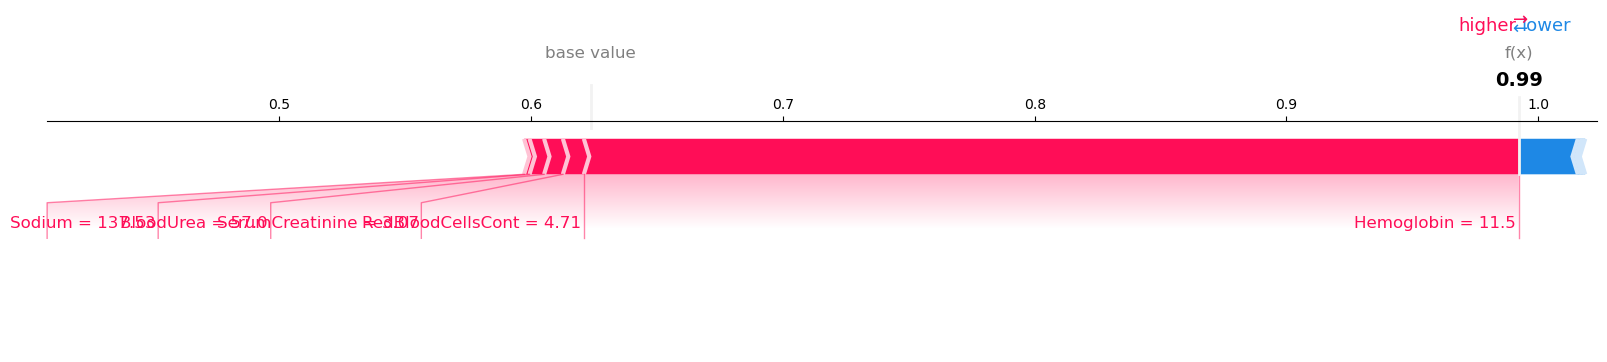

None


In [36]:
 # Initializing JavaScript module
shap.initjs() 
# SHAP force plot for sample 0
print(shap_plot_tree(0))  

__Note__ :You may wonder how we know the average values of the predictors. Remember the SHAP model is built on the training data set. The means of the variables are:

In [37]:
#finding mean values of predictors
x_train.mean()


BloodPressure            76.127778
SpecificGravity           1.017708
Albumin                   1.000000
Sugar                     0.383333
RedBloodCell              0.891667
BloodUrea                55.983889
SerumCreatinine           2.988972
Sodium                  137.563444
Pottasium                 4.641861
Hemoglobin               12.576972
WhiteBloodCellsCont    8437.466667
RedBloodCellsCont         4.720250
Hypertension              0.354833
dtype: float64

In [38]:
#finding mean of target variable
y_test.mean()

0.65

### Analysis:
Let me break this elegant plot in great detail:

- The output value is the prediction for that observation (the prediction of the 0th row is 0.99).
- The base value: The base value  is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction. You may wonder why it is 0.65. This is because the mean prediction of Y_test is 0.56. You can test it out by y_test.mean() which produces 0.65.
- Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.
- Hemoglobin: has a negative impact in predicting kidney disease. The Hemoglobin content of this person(row 0) is 11.5  which is lower than the average value 12.57(=11.5<12.57). So it pushes the prediction to the right.
- RedBloodCellCont:  has a negative impact in predicting kidney disease. The RedBloodCellCont content of this person(row 0) is 14.71  which is lower than the average value 4.72(=4.71.<4.72). So it pushes the prediction to the right. 


###  Interpret Observation 2

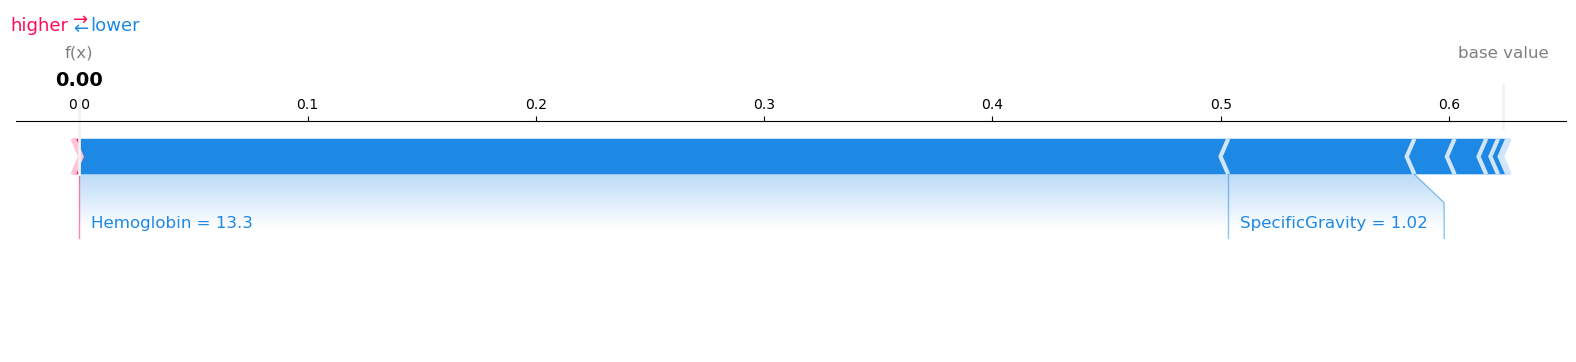

None


In [39]:
# SHAP force plot for sample 1
print(shap_plot_tree(1))  


- The output value is the prediction for that observation (the prediction of the 1st row is 0.0).

- Hemoglobin: has a positive impact in predicting kidney disease. The Hemoglobin content of this person(row 1) is 13.33 which is higher than the average value 12.57(=13.33>12.57). So it pushes the prediction to the left.
- Specific Gravity: has has a positive impact in predicting kidney disease. The Specific gravity  of this person(row 1) is 1.02 which is higher than the average value 1.01(=1.02>1.01). So it pushes the prediction to the left.


## What conclusion can we arrive from the above Force plot SHAP Analysis?

- Each feature has a shap value contributing to the prediction.
- The final prediction = the average prediction + the shap values of all features.
- The shap value of a feature can be positive or negative.
- If a feature is positively correlated to the target, a value higher than its own average will contribute positively to the    prediction.
- If a feature is negatively correlated to the target, a value higher than its own average will contribute negatively to the prediction.


## Heatmap Visualization for Linear and Tree-based model

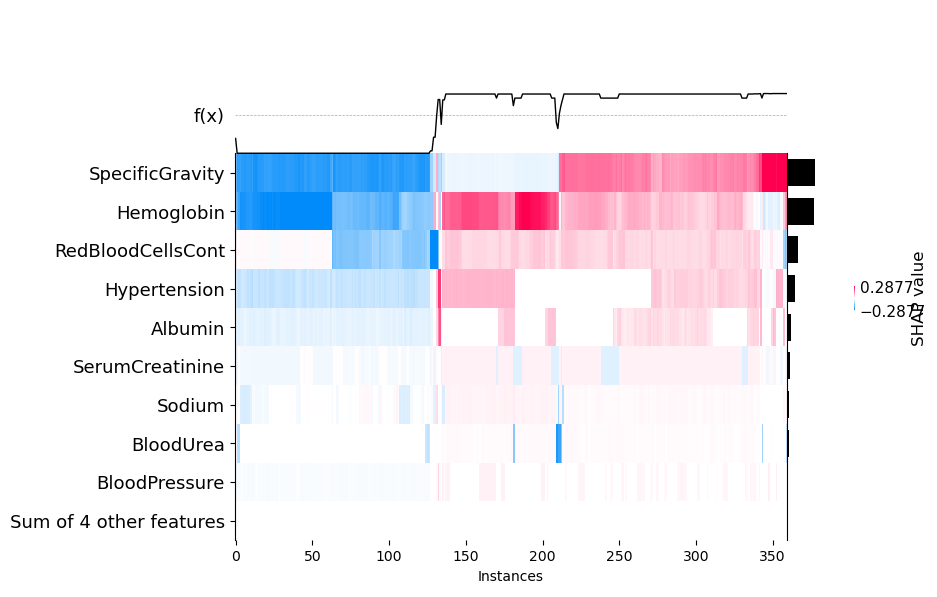

In [40]:

shap.plots.heatmap(tree_shap_values)  # SHAP HeatMap of a Tree Based Model

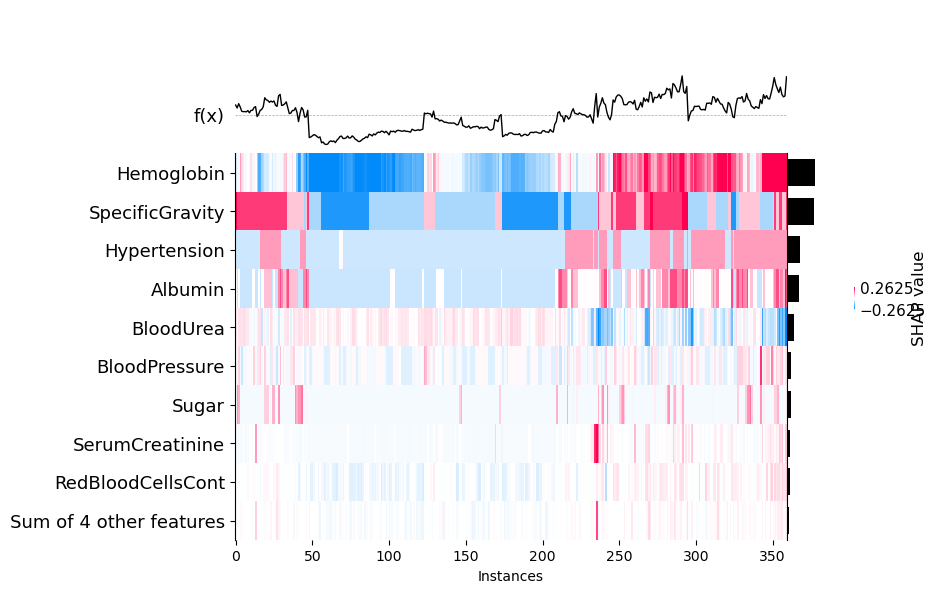

In [41]:
shap.plots.heatmap(linear_shap_values)  # SHAP heatmap for a Linear Model

# LIME (Local Interpretation Model-Agnostic Explanation) Analysis


LIME explains the model’s prediction of an instance by approximating the model with an intrinsically interpretable one like decision trees. Roughly what LIME does is that it takes the model and calls (probes) it many times to understand how or why the model makes its predictions, by comparing how the model acts to different variations of the data, from this probing we will have a new dataset, LIME then train a new interpretable model by nature like decision trees, and each instance is weighted by how close it is to the sample instances of the newly generated dataset.

## Observations

Let us Interpret our Linear model and Tree-based model on sample data (sample_index = 18) using LIME and try to understand what is happening under the hood. Please refer below for Visualizations of both models

- As we can see on the left-hand side LIME gives us information about the minimum and maximum values predicted by the model. The Color orange here represents positive and blue represents negative
- Here for this sample as seen below alcohol, Blood_Pressure,Hemoglobin , Hypertension,Blood_Urea are posotive for both the models.
- Specific gravity ,Sugar,Potassium have negative effect on both models
- Albumin had postive effect in linear model but had negative effect on tree model
- These interpretations were carried out locally in the region where of out sample data(sample_index = 18).

In [50]:

# Initializing LIME explainer for Linear Model
lime_linear_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train), feature_names=x_train.columns, mode="regression"
)

In [51]:

# Getting LIME interpretation for a sample data
idx = 18
np_x_test = np.array(x_test)
np_y_test = np.array(y_test)
print("Prediction : ", linear_model.predict(np_x_test[0].reshape(1, -1)))
print("Actual :     ", np_y_test[idx])

lime_linear_explanation = lime_linear_explainer.explain_instance(
    np_x_test[idx], linear_model.predict, num_features=np_x_test.shape[1]
)
lime_linear_explanation

Prediction :  [0.4902018]
Actual :      1


X does not have valid feature names, but LinearRegression was fitted with feature names
X does not have valid feature names, but LinearRegression was fitted with feature names


### Code Walk through
The above code loads a sample data point from x_test and y_test, makes a prediction using the linear_model, and generates an explanation using LIME. The explanation shows the contribution of each feature to the model's prediction for the selected data point.

In [58]:

lime_linear_explanation.show_in_notebook()  # Display Results in Notebook

In [59]:
# Initializing LIME explainer for Tree Based Model
lime_tree_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train), feature_names=x_train.columns, mode="regression"
)
    

In [60]:

# Getting LIME interpretation for a sample data
idx = 18
np_x_test = np.array(x_test)
np_y_test = np.array(y_test)
print("Prediction : ", tree_model.predict(np_x_test[0].reshape(1, -1)))
print("Actual :     ", np_y_test[idx])

lime_tree_explanation = lime_linear_explainer.explain_instance(
    np_x_test[idx], tree_model.predict, num_features=np_x_test.shape[1]
)
lime_tree_explanation

Prediction :  [0.99220952]
Actual :      1


X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


### Code Walk through
The above code loads a sample data point from x_test and y_test, makes a prediction using the tree_model, and generates an explanation using LIME. The explanation shows the contribution of each feature to the model's prediction for the selected data point.

In [61]:
# Display Results in Notebook
lime_tree_explanation.show_in_notebook()  

## PDP(Partial Dependence Plot) for Linear model and Tree-based Model

A partial dependence plot shows the marginal effect of a feature on the target(Chronic Kidney Disease in out dataset). It is achieved by keeping all other variables constant and changing the value of one variable to get its PDP.

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


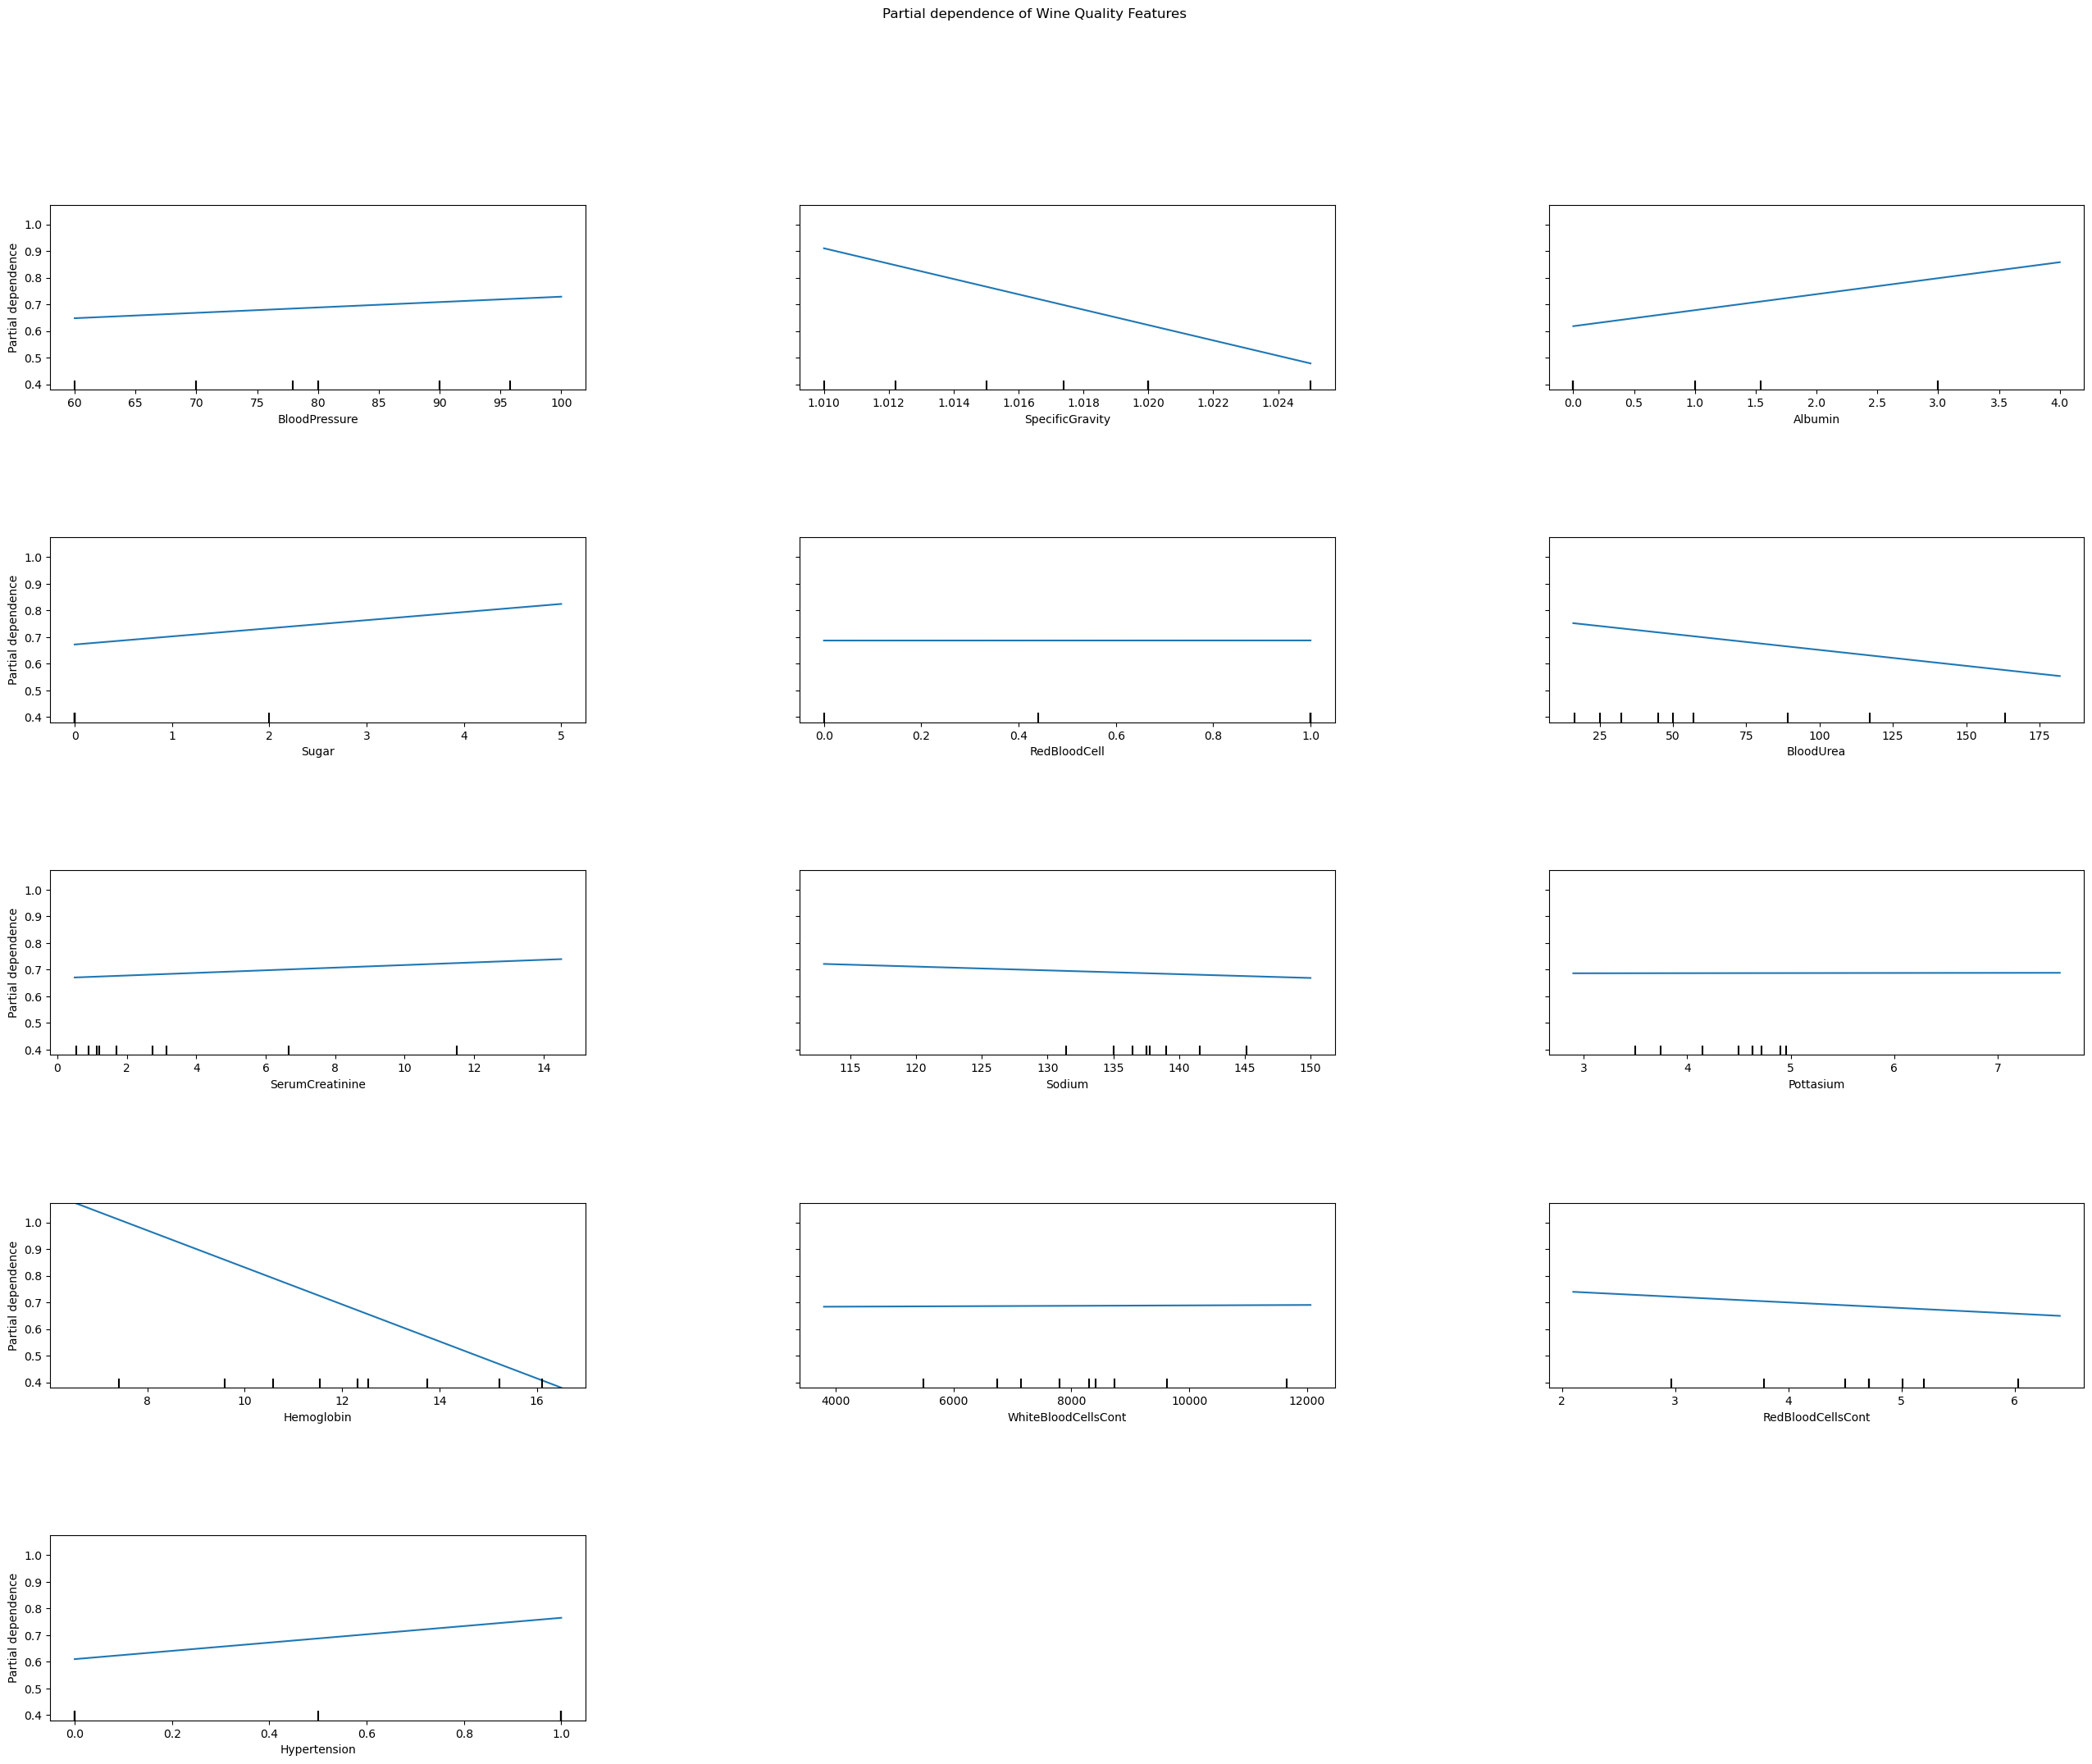

In [56]:

# PDP Plot for Linear Model
plot_partial_dependence(
    linear_model, x_test, x_test.columns, n_jobs=3, grid_resolution=20
)

fig = plt.gcf()
fig.suptitle("Partial dependence of Kidney Disease Features")
fig.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()
plt.rcParams["figure.figsize"] = (32, 24)

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


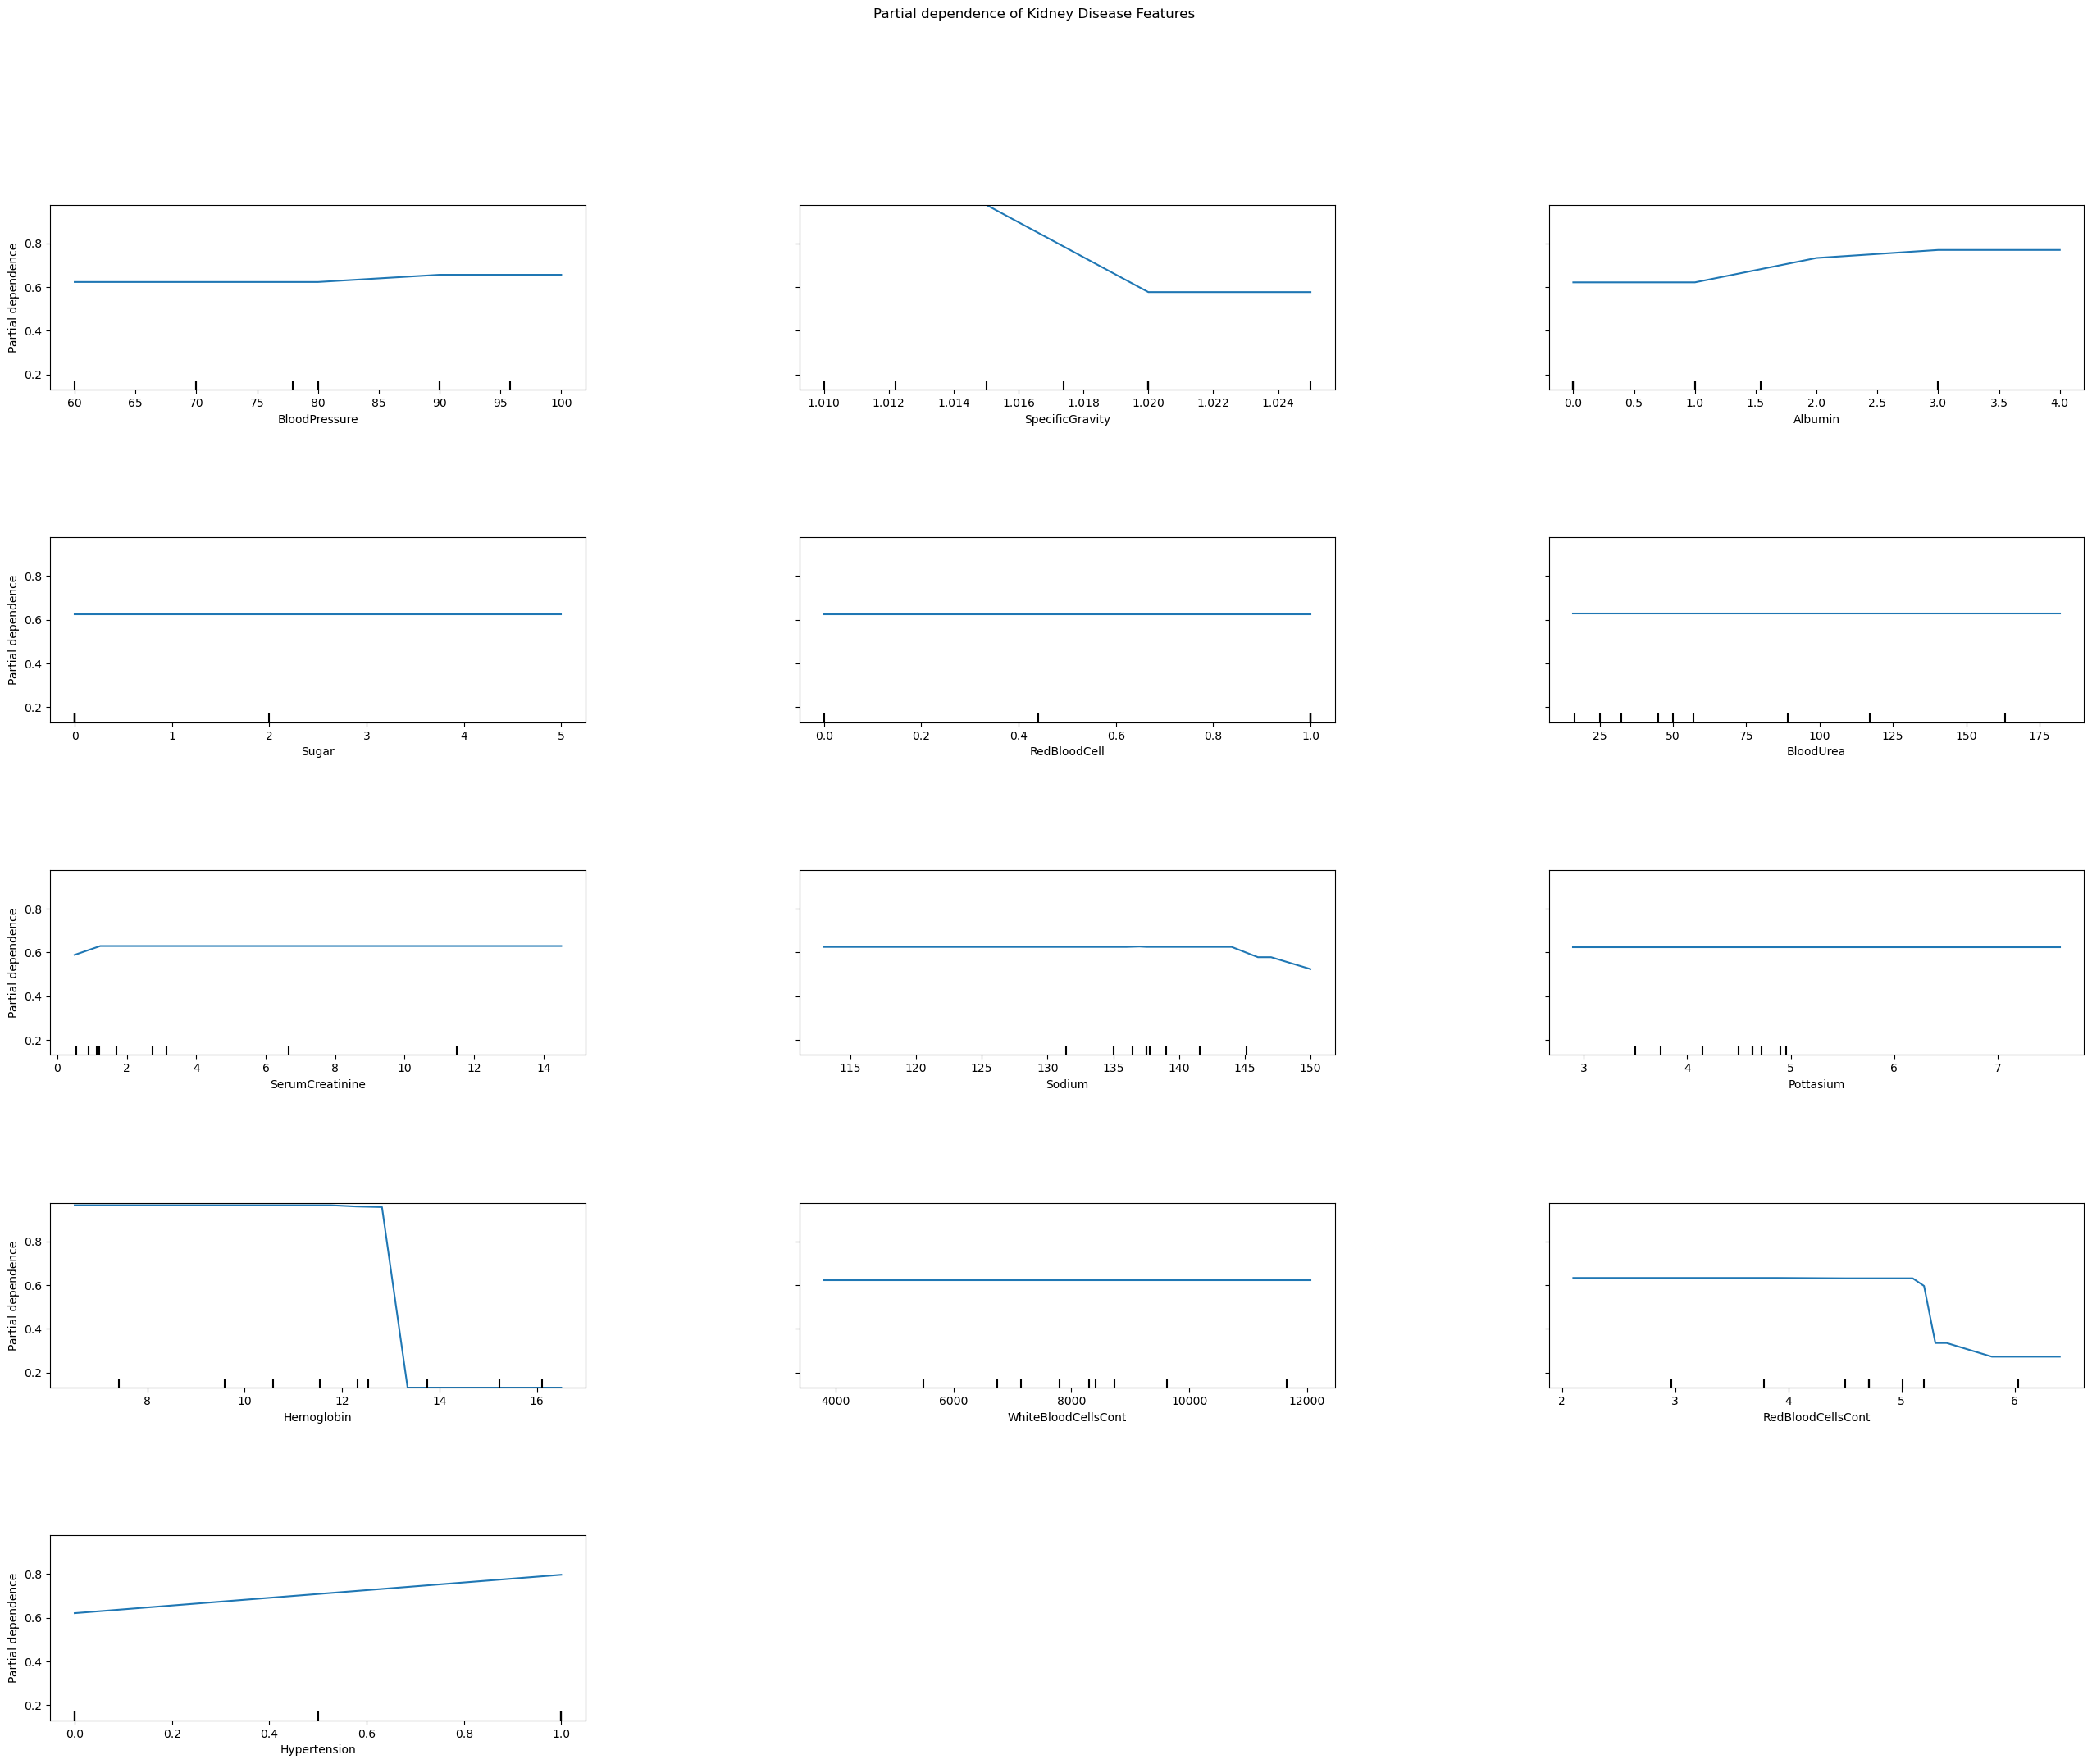

In [62]:
# PDP Plot for Tree based Model
plot_partial_dependence(
    tree_model, x_test, x_test.columns, n_jobs=3, grid_resolution=20
)


fig = plt.gcf()
fig.suptitle("Partial dependence of Kidney Disease Features")
fig.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()
plt.rcParams["figure.figsize"] = (32, 24)

### Observations: 
Linear Model -
If we closely look at the PDP of the linear model we can see that if features volatile_acidity, sulfates, alcohol are tuned while freezing the rest if them the output of the model varies linearly and these variables have the most significant effect on the output(quality of wine) 

2. Tree-Based Model - On looking at the PDP of the tree-based model, it re-affirms the interpretation we got from the PDP of the Linear Model and Best AutoML model. The only difference here is that the output doesn't vary linearly

# Comparision between SHAP, LIME, and Partial Dependence Plot Analysis

Model agnosticism: SHAP and LIME are both model-agnostic techniques, which means that they can be applied to any machine learning model regardless of the underlying algorithm or implementation. PDP analysis, on the other hand, is a model-specific technique that requires knowledge of the underlying model's behavior.
Interpretability: SHAP provides a comprehensive measure of feature importance for both individual predictions and across an entire dataset, while LIME provides local approximations of the model's behavior that are more interpretable for individual predictions. PDP analysis provides an easy way to visualize the marginal effect of a feature on the predicted outcome of a model.
Complexity: SHAP is a more complex technique that involves the computation of Shapley values, which can be computationally expensive for large datasets and complex models. LIME and PDP analysis are generally simpler techniques that can be applied more quickly and easily.

Unlike LIME, SHAP does not necessarily build a local interpretable model but rather uses the black-box model to calculate the marginal contribution to the prediction for each feature and then relies on the theoretically sound game theory concept of Shapley values to calculate the feature importance. In this way, SHAP improves upon LIME due to its greater stability and lack of local linear model assumptions.

PDP gives the extent of effect a variable has on the output by freezing the rest of them
SHAP gives how much each variable contributes to the prediction
LIME is more like SHAP but a lite version of it - It takes the local region of the point of interest and gives us information about the contribution each variable has made to the output
We have to analyze our needs and then consider the tradeoff to select the best suitable interpretable method for the ML model